# Feature extraction

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.io import loadmat
import wfdb
from wfdb import processing
from scipy.signal import peak_widths
import os

In [2]:
def segment_peaks(nsub, nseg, start=0, end=5000):

    # ECG segment
    ecg_mat = loadmat(f"ECG_segments_data/ecg_segments/ecg_sub{nsub}_seg{nseg}.mat")
    ecg = pd.DataFrame({
        't': ecg_mat['t'].squeeze(),
        'signal': ecg_mat['ecg'].squeeze()
    })
    ecg = ecg.reset_index()
    ecg.rename(columns={'index': 'idt'}, inplace=True)
    
    # Annotations
    peaks = pd.read_csv(f'ECG_segments_data/manual_annotations/ecg_sub{nsub}_seg{nseg}_labels.csv', header=None)
    peaks = peaks.reset_index()
    peaks.rename(columns={'index':'id_label', 0: 'idt', 1: 'label_desc', 2: 'label'}, inplace=True)
    
    # BayeSlope
    bayeslope_mat = loadmat(f'ECG_segments_data/Rpeaks_BayeSlope_Pulp/Rpeaks_BayeSlope_sub{nsub}_seg{nseg}.mat')
    bayeslope_array = bayeslope_mat['R_bs_cut']-1 # there is an error in the indexing
    bayeslope = pd.DataFrame(bayeslope_array)
    bayeslope = bayeslope.reset_index()
    bayeslope.rename(columns={'index':'id_BayeSlope', 0: 'idt'}, inplace=True)
    bayeslope['BayeSlope']='R'

    # Error class labels
    if (nsub, nseg)==(7, 5):
        labels = ['No-Error']*len(bayeslope_array)
        labels[17] = 'Noise'
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat') and os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
        labels = ['No-Error']*len(bayeslope_array)
    else:
        labels = ['No-Error']*len(bayeslope_array)
        missed = ['--']*peaks.shape[0]
    bayeslope['error_class_label'] = labels
    peaks['error_missed_label'] = missed
    
    # Merges
    ECG = ecg.merge(bayeslope, how='left', on='idt')\
        .merge(peaks[['id_label', 'idt', 'label', 'error_missed_label']], how='left', on='idt')
    return ECG[(ECG['idt']>=start) & (ECG['idt']<=end)]

In [3]:
def comparitor_segment(nsub, nseg):

    # ECG
    ECG = segment_peaks(nsub, nseg)
    peaks_annotations = ECG[ECG['label']=='R']
    peaks_bayeslope = ECG[ECG['BayeSlope']=='R']

    # Comparitor
    ref_sample = peaks_annotations['idt'].to_numpy()
    test_sample = peaks_bayeslope['idt'].to_numpy()
    fs = 250
    t_tol = 0.050 # 50ms
    window_width = int(t_tol*fs)
    signal = ECG['signal'].to_numpy()
    
    return ECG, processing.compare_annotations(ref_sample, test_sample, window_width, signal)

In [4]:
def segment_features(nsub, nseg):
    ### Segment ###
    ecg, comparitor = comparitor_segment(nsub, nseg)
    
    Peaks = ecg[ecg['BayeSlope']=='R'][['idt', 't', 'signal', 'id_BayeSlope', 'error_class_label']].copy()
    
    ### minimum signal around the peak ###
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important
    signals = ecg['signal'].to_numpy()
    Peaks['left_min_idt'] = np.nan
    Peaks['right_min_idt'] = np.nan
    
    for i, idt in Peaks['idt'].items():
        left = max(idt - 15, 0)
        Peaks.at[i, 'left_min_idt'] = left + np.argmin(signals[left:idt+1])
        right = min(idt + 15, 4999)
        Peaks.at[i, 'right_min_idt'] = idt + np.argmin(signals[idt:right+1])
    
    ### Amplitude and Width ###
    Peaks = Peaks.merge(ecg[['idt', 'signal']], how='left', left_on='left_min_idt', right_on='idt', suffixes=('', '_'))
    Peaks.rename(columns={'signal_': 'left_min_signal'}, inplace=True)
    Peaks = Peaks.merge(ecg[['idt', 'signal']], how='left', left_on='right_min_idt', right_on='idt', suffixes=('', '_'))
    Peaks.rename(columns={'signal_': 'right_min_signal'}, inplace=True)
    Peaks.drop(['idt_'], axis=1, inplace=True)
    
    Peaks['Amplitude'] = Peaks['signal'] - Peaks[['left_min_signal', 'right_min_signal']].min(axis=1)
    Peaks['Width'] = Peaks['right_min_idt'] - Peaks['left_min_idt']
    
    ### Consecutive errors ###
    Peaks['Error_ind'] = 0
    Peaks.loc[Peaks['id_BayeSlope'].isin(comparitor.unmatched_test_inds), 'Error_ind'] = 1
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important
    consecutive_errors = []
    consecutive = 0
    for index, row in Peaks.iterrows():
        if row['Error_ind']==1:
            consecutive += 1
        else:
            consecutive=0
        consecutive_errors.append(consecutive)
    Peaks['consecutive_errors'] = consecutive_errors
    
    ### Previous and next peak features ###
    Peaks.sort_values(by='idt', ascending=True, inplace=True) # just in case, the order is important

    ## To avoid missing values I have decided to fill the ends with the information of the peak next to them ##
    
    # RR intervals
    peaks2 = np.array(Peaks['idt'])
    RR = list(peaks2[1:] - peaks2[:-1])
    Peaks['RR_pre'] = [np.nan]+RR
    Peaks['RR_post'] = RR+[np.nan]
    
    # Amplitudes
    amplitudes = np.array(Peaks['Amplitude'])
    Peaks['A_pre'] = [np.nan] + list(amplitudes[:-1])
    Peaks['A_post'] = list(amplitudes[1:]) + [np.nan]
    
    # Widths
    widths = np.array(Peaks['Width'])
    Peaks['W_pre'] = [np.nan] + list(widths[:-1])
    Peaks['W_post'] = list(widths[1:]) + [np.nan]
    
    # Error isolation
    errors = np.array(Peaks['Error_ind'])
    Peaks['error_pre'] = [np.nan] + list(errors[:-1])
    Peaks['error_post'] = list(errors[1:]) + [np.nan]
    
    ### Error dataset ###
    Errors = Peaks[Peaks['Error_ind']==1].copy()
    
    # Error isolation
    Errors['Isolated'] = (Errors['error_pre'] + Errors['error_post']).apply(lambda x: 0 if x >= 1 else 1)
    
    # Ratios
    Errors['RR_ratio'] = Errors['RR_post']/Errors['RR_pre']
    Errors['A_pre_ratio'] = Errors['Amplitude']/Errors['A_pre']
    Errors['A_post_ratio'] = Errors['Amplitude']/Errors['A_post']
    Errors['W_pre_ratio'] = Errors['Width']/Errors['W_pre']
    Errors['W_post_ratio'] = Errors['Width']/Errors['W_post']

    ### Finish ###
    Errors.reset_index(drop=True, inplace=True)
    Errors.reset_index(drop=False, inplace=True)
    Errors.rename(columns={'index': 'id_error'}, inplace=True)
    Errors['id_subject'] = nsub
    Errors['id_segment'] = nseg
    
    # format
    Errors['id_BayeSlope'] = Errors['id_BayeSlope'].astype('int64')
    Errors['Width'] = Errors['Width'].astype('int64')
    Errors['consecutive_errors'] = Errors['consecutive_errors'].astype('int64')

    
    # order
    Errors = Errors[[
        'id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
        'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
        'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio',
        'RR_pre', 'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
        'error_class_label'
    ]]
    
    return Errors

In [5]:
errors_list = [(2, 1), (2, 3), (2, 4), (2, 5), (4, 4), (4, 5), (6, 3), (7, 1), (7, 2), (7, 3),
               (7, 4), (7, 5), (13, 2), (13, 4), (15, 4), (21, 4), (22, 2)]

first=True
for nsub, nseg in errors_list:
    segment_data = segment_features(nsub, nseg)
    if first==True:
        Errors = segment_data
        first = False
    else:
        Errors = pd.concat([Errors, segment_data], ignore_index=True)
Errors.shape

(139, 23)

In [6]:
# There are 3 errors that in reality they are not errors, they are peaks so close to the end or the beginning of the ECG that there was no enough information to annotate a peak, so we will not take into account those errors
print(Errors[(Errors['id_subject']==13) & (Errors['id_segment']==2)])
print(Errors[(Errors['id_subject']==13) & (Errors['id_segment']==4)])
print(Errors[(Errors['id_subject']==15) & (Errors['id_segment']==4)])
Errors = Errors[Errors['error_class_label']!='No-Error']
Errors.shape

     id_subject  id_segment  id_error   idt            t  id_BayeSlope  \
131          13           2         0  1837  1018.378493            19   
132          13           2         1  4998  1031.022524            55   

     signal  Amplitude  A_pre  A_pre_ratio  ...  W_pre  W_pre_ratio  W_post  \
131     465        451  600.0     0.751667  ...   15.0     2.000000    13.0   
132     262        313  260.0     1.203846  ...   23.0     0.347826     NaN   

     W_post_ratio  RR_pre  RR_post  RR_ratio  consecutive_errors  Isolated  \
131      2.307692   211.0    134.0  0.635071                   1         1   
132           NaN    87.0      NaN       NaN                   1         1   

     error_class_label  
131              Noise  
132           No-Error  

[2 rows x 23 columns]
     id_subject  id_segment  id_error  idt           t  id_BayeSlope  signal  \
133          13           4         0    1  1446.01154             0      76   

     Amplitude  A_pre  A_pre_ratio  ...  W_pr

(136, 23)

In [7]:
Errors.head()

id_subject  id_segment  id_error   idt           t  id_BayeSlope  signal  \
0           2           1         0  1630  934.850406            19     153   
1           2           1         1  1822  935.618408            21      64   
2           2           1         2  1881  935.854409            22      68   
3           2           1         3  1963  936.182410            23      93   
4           2           1         4  2043  936.502411            24      93   

   Amplitude  A_pre  A_pre_ratio  ...  W_pre  W_pre_ratio  W_post  \
0        131  124.0     1.056452  ...   15.0     2.000000    16.0   
1         74  141.0     0.524823  ...   16.0     0.875000    28.0   
2         49   74.0     0.662162  ...   14.0     2.000000    27.0   
3         80   49.0     1.632653  ...   28.0     0.964286    20.0   
4         98   80.0     1.225000  ...   27.0     0.740741    24.0   

   W_post_ratio  RR_pre  RR_post  RR_ratio  consecutive_errors  Isolated  \
0      1.875000   118.0    127.0  1.076271                   1         1   
1      0.500000    65.0     59.0  0.907692                   1         0   
2      1.037037    59.0     82.0  1.389831                   2         0   
3      1.350000    82.0     80.0  0.975610                   3         0   
4      0.833333    80.0    122.0  1.525000                   4         0   

   error_class_label  
0             T-wave  
1              Noise  
2             T-wave  
3             T-wave  
4             T-wave  

[5 rows x 23 columns]

In [8]:
Errors.to_csv("Unsupervised_learning/Error_features.csv", index=False)

# Data processing

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [10]:
errors_all = pd.read_csv("Unsupervised_learning/Error_features.csv")
errors_all.describe()

id_subject  id_segment    id_error          idt            t  \
count  136.000000  136.000000  136.000000   136.000000   136.000000   
mean     3.507353    3.404412   16.470588  2717.625000  1323.454284   
std      3.777117    0.953579   15.448333  1283.289205   158.384624   
min      2.000000    1.000000    0.000000    43.000000   919.118425   
25%      2.000000    3.000000    3.000000  1801.750000  1323.493471   
50%      2.000000    4.000000   11.500000  2655.500000  1333.361432   
75%      2.000000    4.000000   28.250000  3816.750000  1367.260519   
max     22.000000    5.000000   53.000000  4947.000000  1940.203581   

       id_BayeSlope       signal    Amplitude        A_pre  A_pre_ratio  ...  \
count    136.000000   136.000000   136.000000   134.000000   134.000000  ...   
mean      32.970588   151.367647   179.779412   170.828358     1.887548  ...   
std       17.720857   140.730728   217.285192   241.339543     3.412570  ...   
min        0.000000   -97.000000    26.000000    26.000000     0.045740  ...   
25%       19.000000    85.750000    86.000000    82.250000     0.666066  ...   
50%       32.500000   135.000000   120.000000   119.000000     1.046574  ...   
75%       48.250000   172.500000   169.500000   160.000000     1.778366  ...   
max       64.000000  1399.000000  1352.000000  2148.000000    29.058824  ...   

            Width       W_pre  W_pre_ratio      W_post  W_post_ratio  \
count  136.000000  134.000000   134.000000  134.000000    134.000000   
mean    25.411765   23.738806     1.193110   23.970149      1.181217   
std      6.079072    6.798860     0.574444    6.804400      0.563353   
min      7.000000    7.000000     0.321429    7.000000      0.259259   
25%     23.000000   18.000000     0.926587   18.000000      0.925066   
50%     28.000000   27.000000     1.000000   27.000000      1.000000   
75%     30.000000   30.000000     1.258152   30.000000      1.237500   
max     30.000000   30.000000     3.857143   30.000000      3.111111   

           RR_pre     RR_post    RR_ratio  consecutive_errors    Isolated  
count  134.000000  134.000000  132.000000          136.000000  136.000000  
mean    91.186567   94.014925    1.118180           12.911765    0.132353  
std     62.377479   54.573119    0.532071           13.700755    0.340127  
min     56.000000   49.000000    0.458515            1.000000    0.000000  
25%     71.000000   72.000000    0.916373            2.000000    0.000000  
50%     75.000000   76.000000    0.984435            6.500000    0.000000  
75%     80.000000   86.750000    1.075038           21.250000    0.000000  
max    654.000000  461.000000    4.153153           49.000000    1.000000  

[8 rows x 22 columns]

### Missing values

In [11]:
# remove rows with missing values
print(errors_all.shape)
errors = errors_all.dropna().reset_index(drop=True)
print(errors.shape)
print("% of rows with NaN: ", f'{(errors_all.shape[0]-errors.shape[0])/errors_all.shape[0]}%')

(136, 23)
(132, 23)
% of rows with NaN:  0.029411764705882353%


### Scaling

In [12]:
# metrics
errors['Amplitude_scl'] = StandardScaler().fit_transform(np.array(errors['Amplitude']).reshape(-1, 1))
errors['A_pre_scl'] = StandardScaler().fit_transform(np.array(errors['A_pre']).reshape(-1, 1))
errors['A_post_scl'] = StandardScaler().fit_transform(np.array(errors['A_post']).reshape(-1, 1))
errors['Width_scl'] = StandardScaler().fit_transform(np.array(errors['Width']).reshape(-1, 1))
errors['W_pre_scl'] = StandardScaler().fit_transform(np.array(errors['W_pre']).reshape(-1, 1))
errors['W_post_scl'] = StandardScaler().fit_transform(np.array(errors['W_post']).reshape(-1, 1))
errors['RR_pre_scl'] = StandardScaler().fit_transform(np.array(errors['RR_pre']).reshape(-1, 1))
errors['RR_post_scl'] = StandardScaler().fit_transform(np.array(errors['RR_post']).reshape(-1, 1))
# counters
errors['consecutive_errors_scl'] = StandardScaler().fit_transform(np.array(errors['consecutive_errors']).reshape(-1, 1))

In [13]:
# ratios
errors['A_pre_ratio_log'] = np.log(errors['A_pre_ratio'].tolist())
errors['A_post_ratio_log'] = np.log(errors['A_post_ratio'].tolist())
errors['W_pre_ratio_log'] = np.log(errors['W_pre_ratio'].tolist())
errors['W_post_ratio_log'] = np.log(errors['W_post_ratio'].tolist())
errors['RR_ratio_log'] = np.log(errors['RR_ratio'].tolist())

errors['A_pre_ratio_scl'] = StandardScaler().fit_transform(np.array(errors['A_pre_ratio_log']).reshape(-1, 1))
errors['A_post_ratio_scl'] = StandardScaler().fit_transform(np.array(errors['A_post_ratio_log']).reshape(-1, 1))
errors['W_pre_ratio_scl'] = StandardScaler().fit_transform(np.array(errors['W_pre_ratio_log']).reshape(-1, 1))
errors['W_post_ratio_scl'] = StandardScaler().fit_transform(np.array(errors['W_post_ratio_log']).reshape(-1, 1))
errors['RR_ratio_scl'] = StandardScaler().fit_transform(np.array(errors['RR_ratio_log']).reshape(-1, 1))

In [14]:
errors.describe()

id_subject  id_segment    id_error          idt            t  \
count  132.000000  132.000000  132.000000   132.000000   132.000000   
mean     3.515152    3.401515   16.287879  2724.227273  1323.126946   
std      3.815366    0.963928   15.111560  1230.392376   160.644155   
min      2.000000    1.000000    0.000000   122.000000   919.118425   
25%      2.000000    3.000000    3.000000  1821.500000  1323.493471   
50%      2.000000    4.000000   11.500000  2655.500000  1333.059431   
75%      2.000000    4.000000   28.000000  3768.250000  1367.260519   
max     22.000000    5.000000   52.000000  4876.000000  1940.203581   

       id_BayeSlope       signal    Amplitude        A_pre  A_pre_ratio  ...  \
count    132.000000   132.000000   132.000000   132.000000   132.000000  ...   
mean      33.000000   152.310606   181.871212   171.265152     1.904624  ...   
std       17.097386   142.667506   220.192019   243.121961     3.435444  ...   
min        1.000000   -97.000000    26.000000    26.000000     0.045740  ...   
25%       19.000000    84.750000    86.000000    81.500000     0.673874  ...   
50%       32.500000   135.000000   120.000000   119.000000     1.046574  ...   
75%       48.000000   174.250000   171.000000   156.000000     1.830642  ...   
max       63.000000  1399.000000  1352.000000  2148.000000    29.058824  ...   

       A_pre_ratio_log  A_post_ratio_log  W_pre_ratio_log  W_post_ratio_log  \
count       132.000000        132.000000       132.000000        132.000000   
mean          0.067012          0.055181         0.077159          0.062616   
std           0.999040          0.830587         0.447913          0.446277   
min          -3.084784         -2.516655        -1.134980         -1.349927   
25%          -0.394763         -0.359910        -0.082742         -0.080043   
50%           0.045478          0.048990         0.000000          0.000000   
75%           0.604023          0.442813         0.261701          0.182322   
max           3.369322          3.084784         1.349927          1.134980   

       RR_ratio_log  A_pre_ratio_scl  A_post_ratio_scl  W_pre_ratio_scl  \
count    132.000000     1.320000e+02      1.320000e+02     1.320000e+02   
mean       0.041409    -6.728624e-18      1.345725e-17     3.364312e-17   
std        0.342185     1.003810e+00      1.003810e+00     1.003810e+00   
min       -0.779762    -3.166843e+00     -3.108205e+00    -2.716503e+00   
25%       -0.087332    -4.639797e-01     -5.016606e-01    -3.583509e-01   
50%       -0.015689    -2.163709e-02     -7.481714e-03    -1.729201e-01   
75%        0.072356     5.395748e-01      4.684745e-01     4.135725e-01   
max        1.423868     3.318075e+00      3.661442e+00     2.852376e+00   

       W_post_ratio_scl  RR_ratio_scl  
count        132.000000  1.320000e+02  
mean           0.000000  3.364312e-18  
std            1.003810  1.003810e+00  
min           -3.177231 -2.408927e+00  
25%           -0.320883 -3.776652e-01  
50%           -0.140843 -1.674994e-01  
75%            0.269253  9.078216e-02  
max            2.412066  4.055479e+00  

[8 rows x 41 columns]

### Outliers

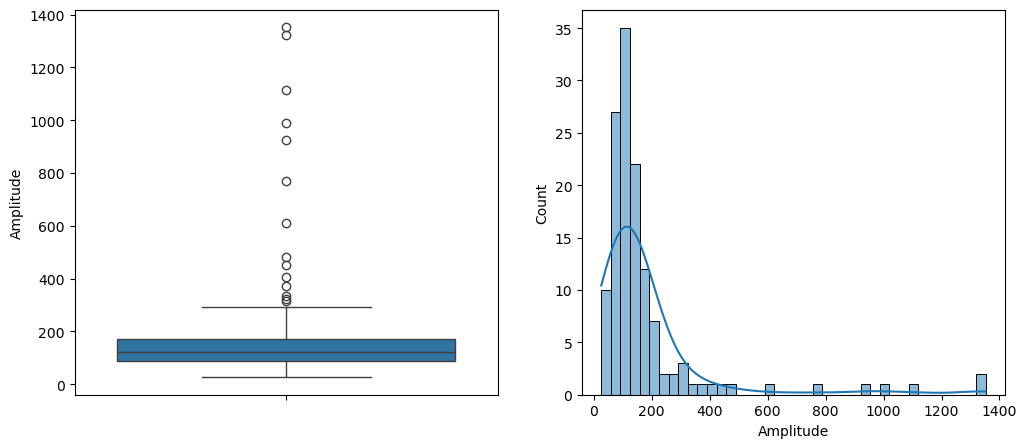

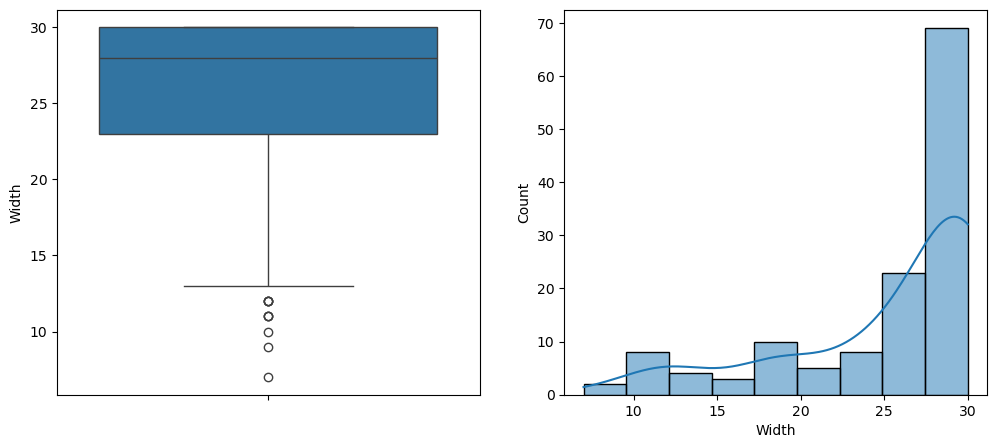

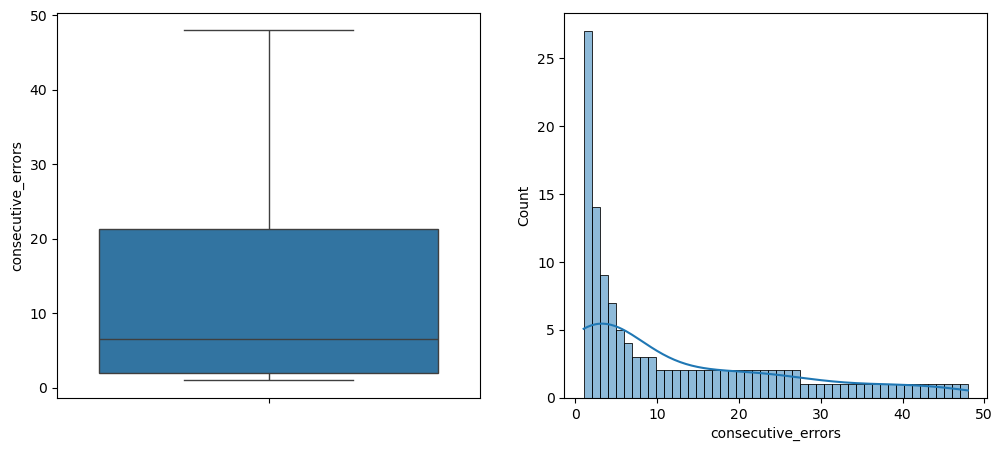

In [15]:
f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['Amplitude'], ax=a[0])
sns.histplot(errors['Amplitude'], ax=a[1], kde=True)
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['Width'], ax=a[0])
sns.histplot(errors['Width'], ax=a[1], kde=True)
plt.show()

f, a = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(errors['consecutive_errors'], ax=a[0])
sns.histplot(errors['consecutive_errors'], ax=a[1], kde=True, bins=48)
plt.show()

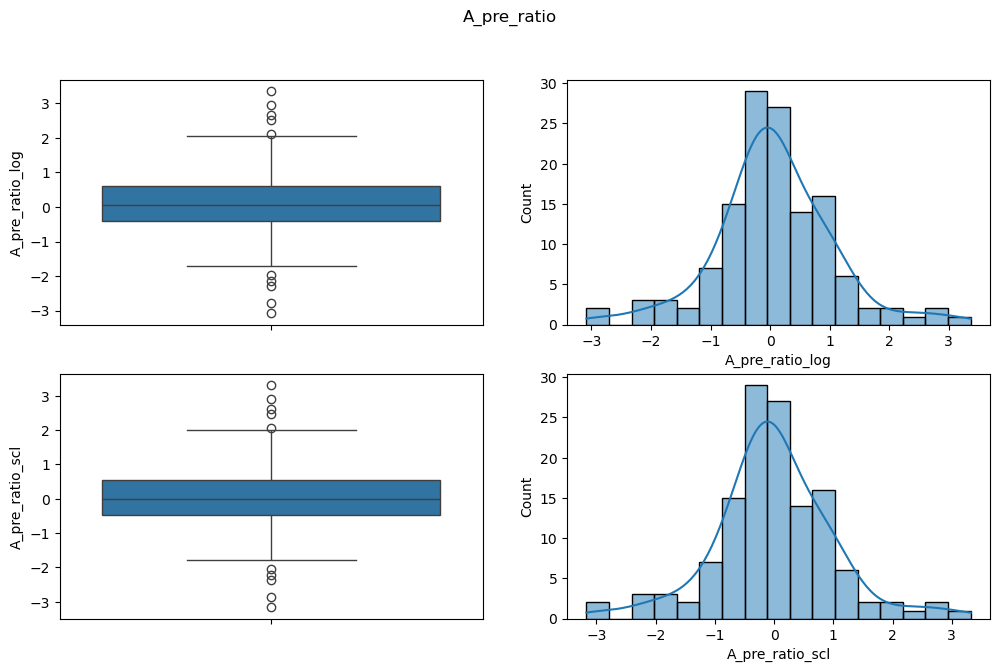

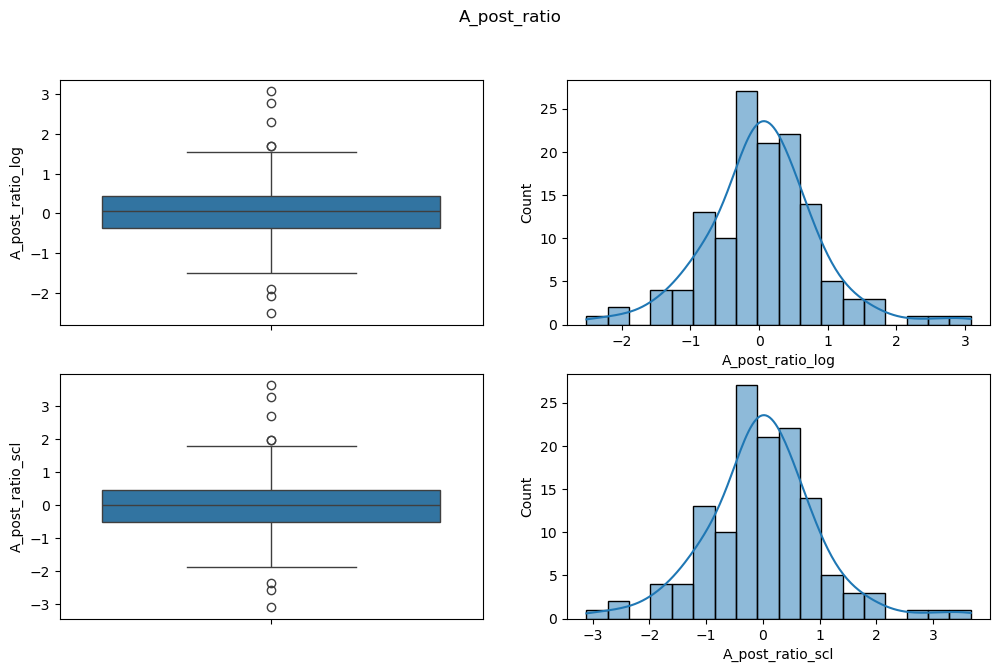

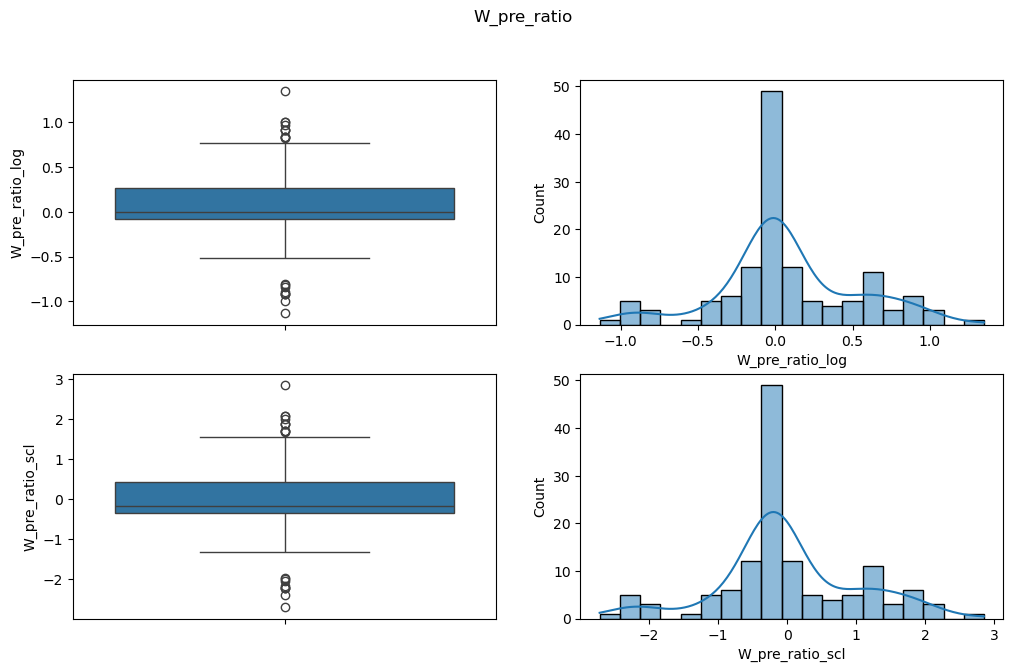

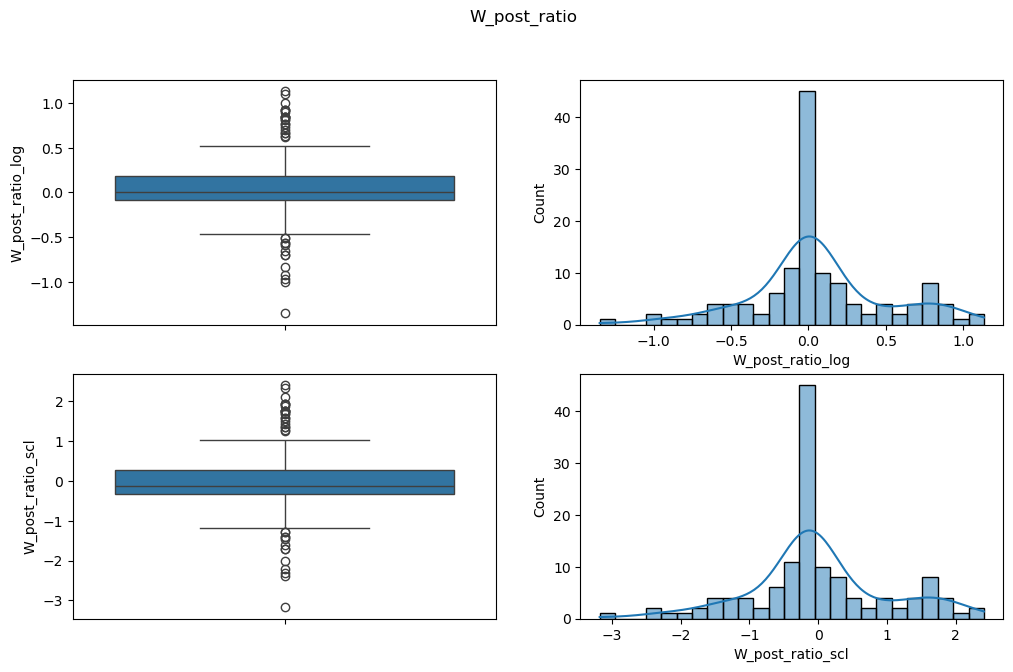

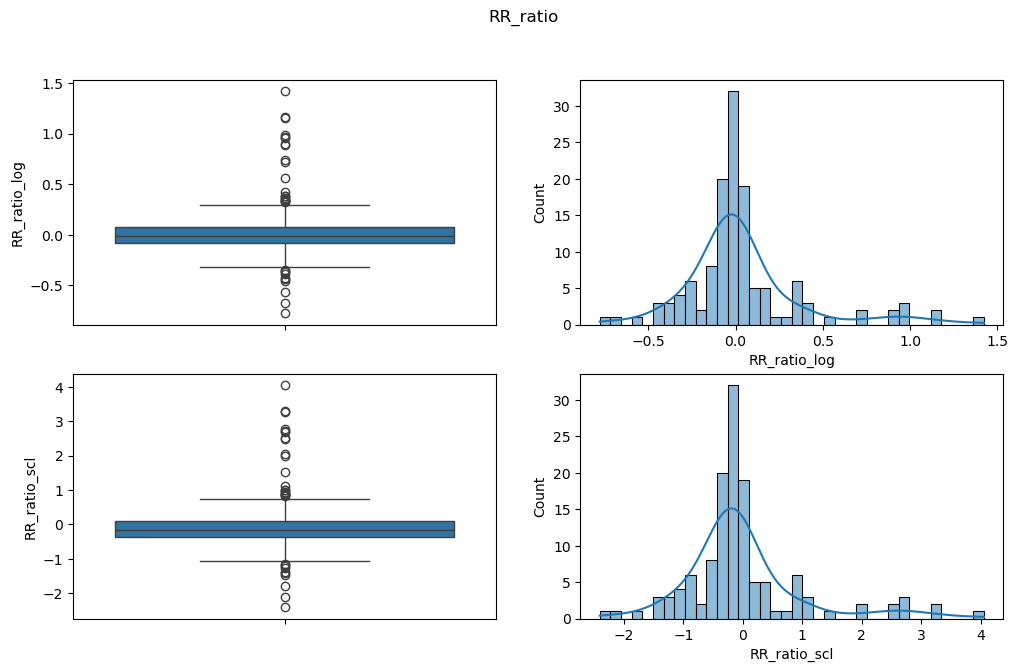

In [16]:
f, a = plt.subplots(2, 2, figsize=(12, 7))
sns.boxplot(errors['A_pre_ratio_log'], ax=a[0, 0])
sns.histplot(errors['A_pre_ratio_log'], ax=a[0, 1], kde=True)
sns.boxplot(errors['A_pre_ratio_scl'], ax=a[1, 0])
sns.histplot(errors['A_pre_ratio_scl'], ax=a[1, 1], kde=True)
f.suptitle('A_pre_ratio')
plt.show()

f, a = plt.subplots(2, 2, figsize=(12, 7))
sns.boxplot(errors['A_post_ratio_log'], ax=a[0, 0])
sns.histplot(errors['A_post_ratio_log'], ax=a[0, 1], kde=True)
sns.boxplot(errors['A_post_ratio_scl'], ax=a[1, 0])
sns.histplot(errors['A_post_ratio_scl'], ax=a[1, 1], kde=True)
f.suptitle('A_post_ratio')
plt.show()

f, a = plt.subplots(2, 2, figsize=(12, 7))
sns.boxplot(errors['W_pre_ratio_log'], ax=a[0, 0])
sns.histplot(errors['W_pre_ratio_log'], ax=a[0, 1], kde=True)
sns.boxplot(errors['W_pre_ratio_scl'], ax=a[1, 0])
sns.histplot(errors['W_pre_ratio_scl'], ax=a[1, 1], kde=True)
f.suptitle('W_pre_ratio')
plt.show()

f, a = plt.subplots(2, 2, figsize=(12, 7))
sns.boxplot(errors['W_post_ratio_log'], ax=a[0, 0])
sns.histplot(errors['W_post_ratio_log'], ax=a[0, 1], kde=True)
sns.boxplot(errors['W_post_ratio_scl'], ax=a[1, 0])
sns.histplot(errors['W_post_ratio_scl'], ax=a[1, 1], kde=True)
f.suptitle('W_post_ratio')
plt.show()

f, a = plt.subplots(2, 2, figsize=(12, 7))
sns.boxplot(errors['RR_ratio_log'], ax=a[0, 0])
sns.histplot(errors['RR_ratio_log'], ax=a[0, 1], kde=True)
sns.boxplot(errors['RR_ratio_scl'], ax=a[1, 0])
sns.histplot(errors['RR_ratio_scl'], ax=a[1, 1], kde=True)
f.suptitle('RR_ratio')
plt.show()

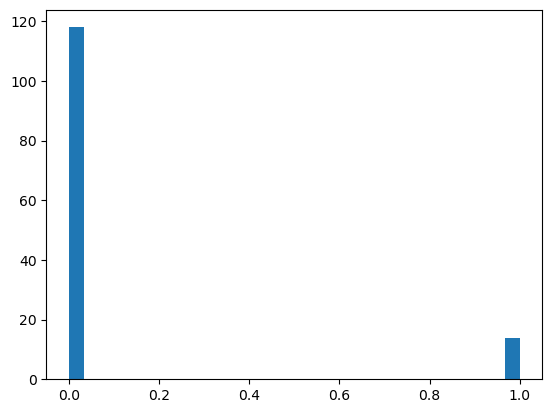

In [17]:
plt.hist(errors['Isolated'], bins=30)
plt.show()

In [18]:
errors.to_csv("Unsupervised_learning/Error_processed.csv", index=False)

# Feature selection

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

In [20]:
errors = pd.read_csv("Unsupervised_learning/Error_processed.csv")
errors.keys()

Index(['id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
       'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
       'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio', 'RR_pre',
       'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
       'error_class_label', 'Amplitude_scl', 'A_pre_scl', 'A_post_scl',
       'Width_scl', 'W_pre_scl', 'W_post_scl', 'RR_pre_scl', 'RR_post_scl',
       'consecutive_errors_scl', 'A_pre_ratio_log', 'A_post_ratio_log',
       'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log',
       'A_pre_ratio_scl', 'A_post_ratio_scl', 'W_pre_ratio_scl',
       'W_post_ratio_scl', 'RR_ratio_scl'],
      dtype='object')

### Multicolineality

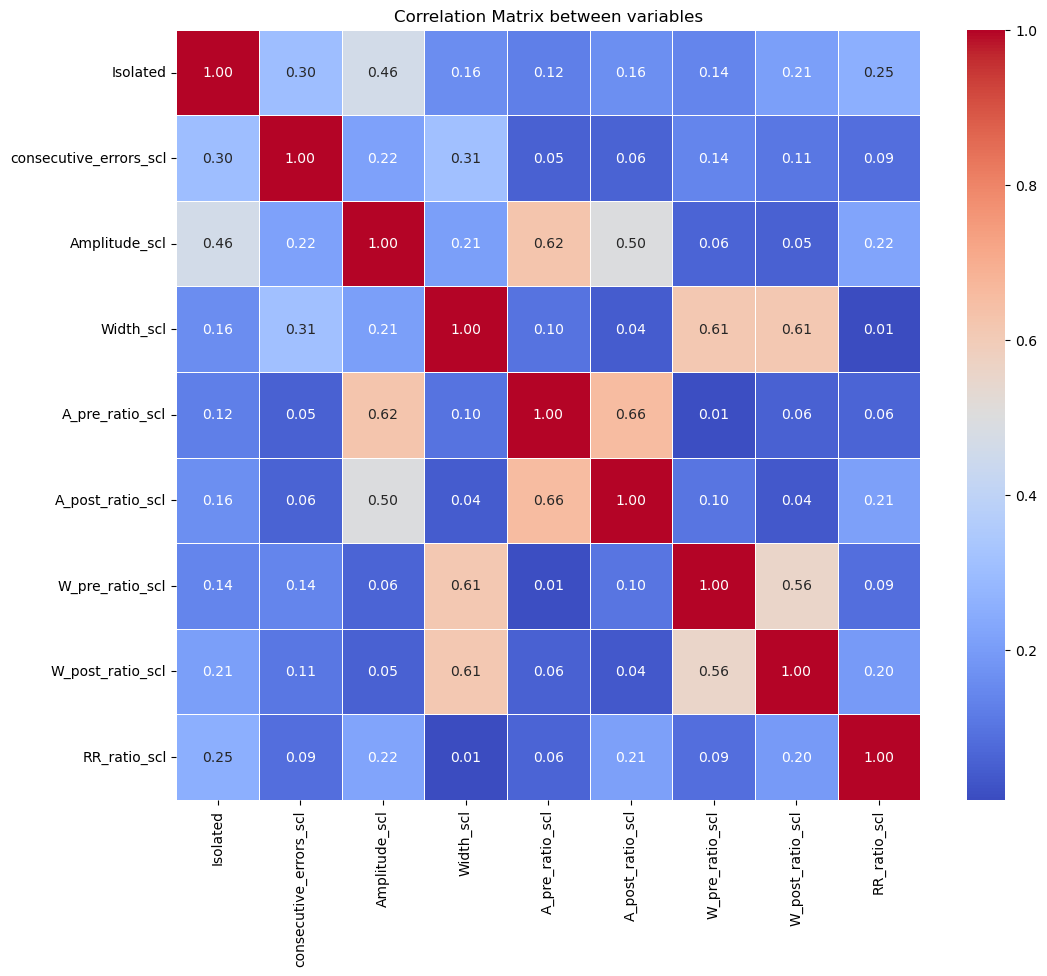

In [21]:
variables = errors[['Isolated', 'consecutive_errors_scl', 'Amplitude_scl', 'Width_scl',
                    'A_pre_ratio_scl', 'A_post_ratio_scl', 'W_pre_ratio_scl', 'W_post_ratio_scl', 'RR_ratio_scl']]

correlations = variables.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix between variables')
plt.show()

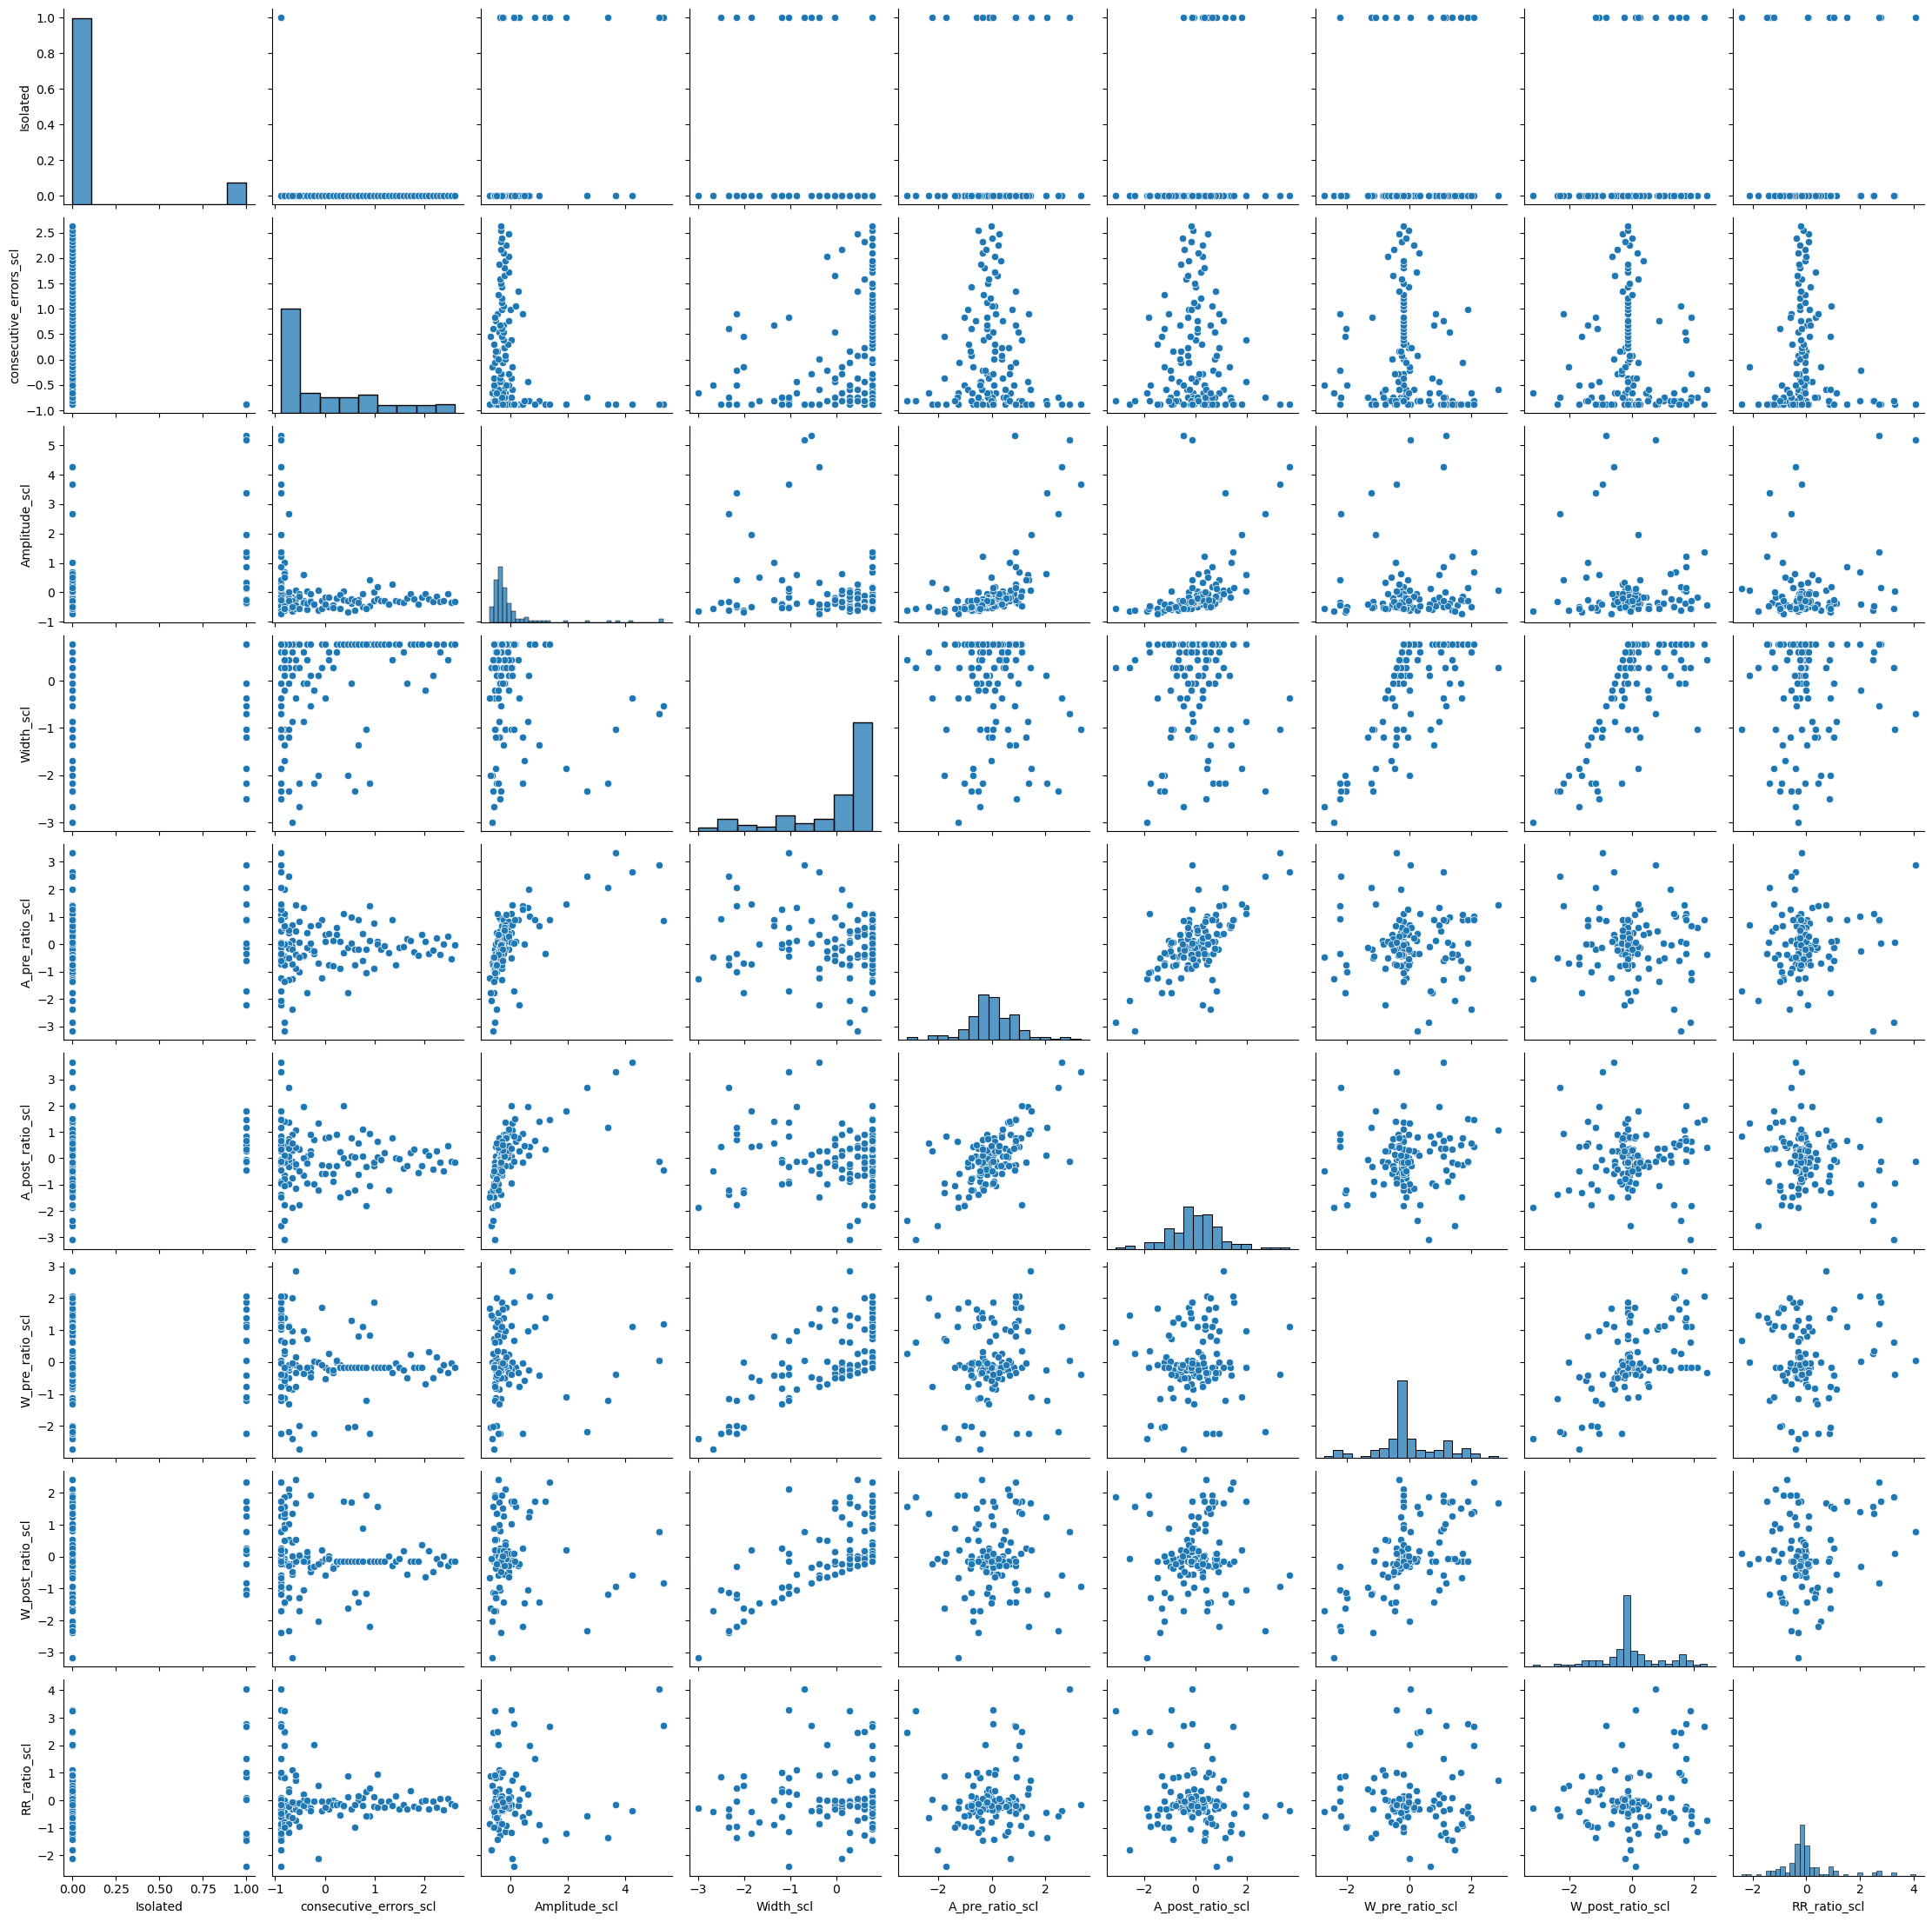

In [22]:
sns.pairplot(variables)

For now, I will use the following variables:
* Isolated
* consecutive_errors
* Amplitude
* Width
* A_pre_ratio
* A_post_ratio
* W_pre_ratio
* W_post_ratio
* RR_ratio

# Models

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [24]:
errors = pd.read_csv("Unsupervised_learning/Error_processed.csv")
errors.keys()

Index(['id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope',
       'signal', 'Amplitude', 'A_pre', 'A_pre_ratio', 'A_post', 'A_post_ratio',
       'Width', 'W_pre', 'W_pre_ratio', 'W_post', 'W_post_ratio', 'RR_pre',
       'RR_post', 'RR_ratio', 'consecutive_errors', 'Isolated',
       'error_class_label', 'Amplitude_scl', 'A_pre_scl', 'A_post_scl',
       'Width_scl', 'W_pre_scl', 'W_post_scl', 'RR_pre_scl', 'RR_post_scl',
       'consecutive_errors_scl', 'A_pre_ratio_log', 'A_post_ratio_log',
       'W_pre_ratio_log', 'W_post_ratio_log', 'RR_ratio_log',
       'A_pre_ratio_scl', 'A_post_ratio_scl', 'W_pre_ratio_scl',
       'W_post_ratio_scl', 'RR_ratio_scl'],
      dtype='object')

In [25]:
errors_classes = errors[[
    'id_subject', 'id_segment', 'id_error', 'idt', 't', 'id_BayeSlope', 'error_class_label'
]]

In [26]:
errors2 = errors[[
    'Isolated', 'consecutive_errors_scl',
    'Amplitude_scl', 'Width_scl',
    'A_pre_ratio_scl', 'A_post_ratio_scl', 'W_pre_ratio_scl', 'W_post_ratio_scl', 'RR_ratio_scl'
]]

In [27]:
SCORE_columns = ['model', 'params', 'silhouette', 'calinski-harabasz', 'davies-bouldin']
SCORE_rows = []

### Model 1: K_means

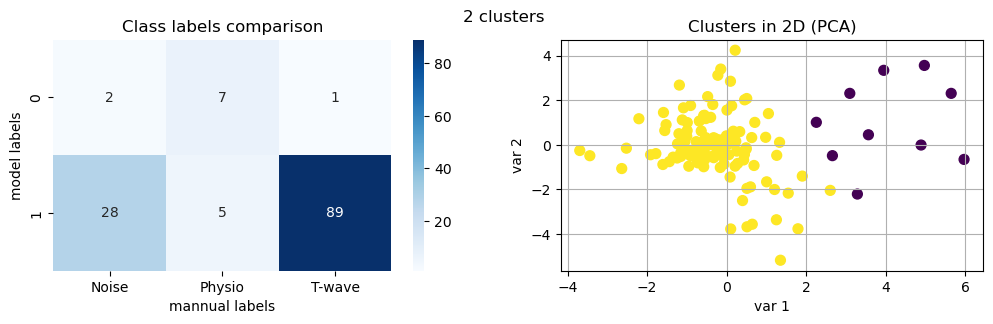

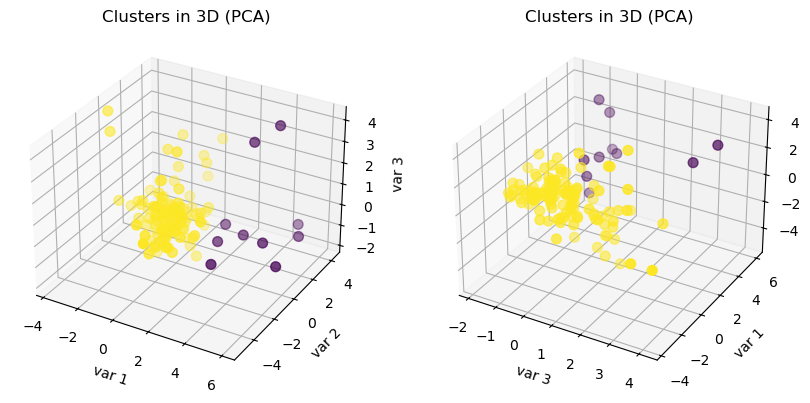

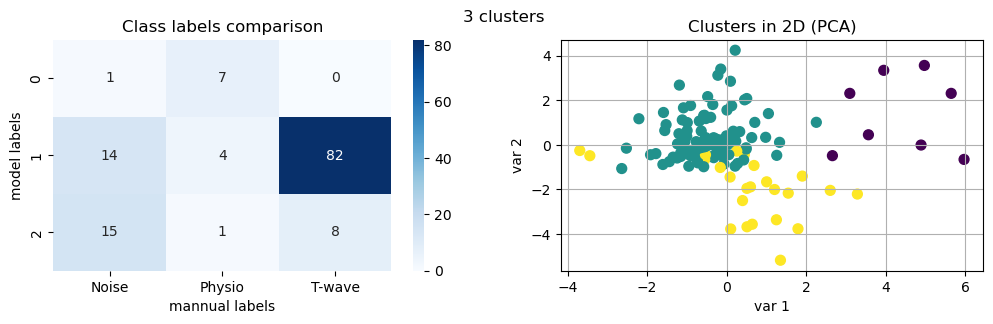

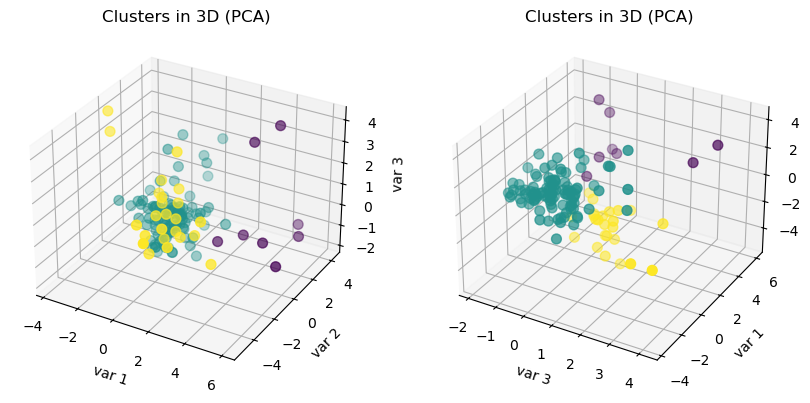

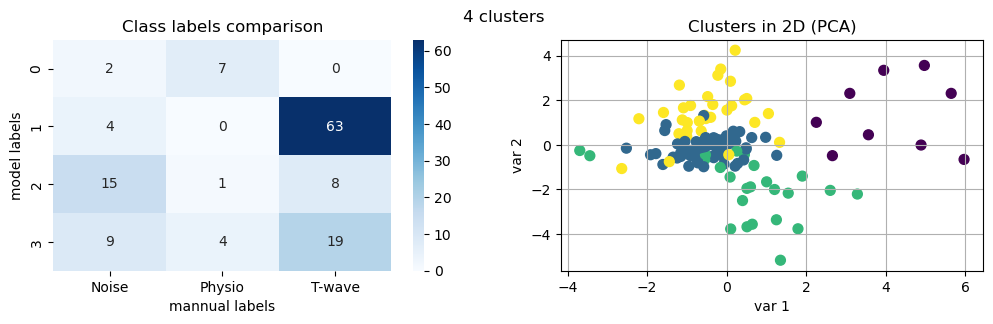

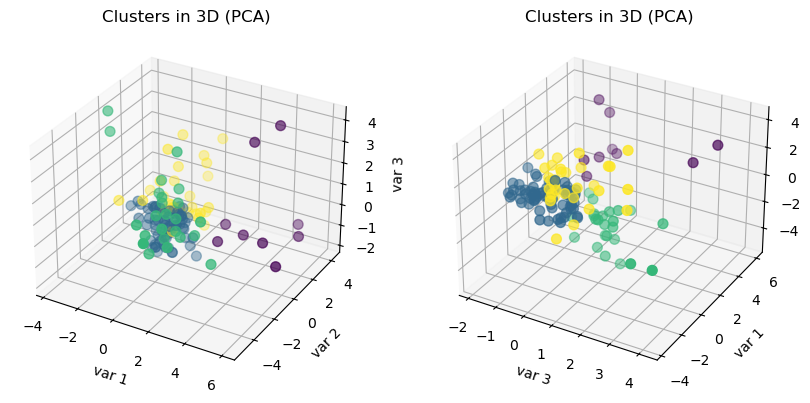

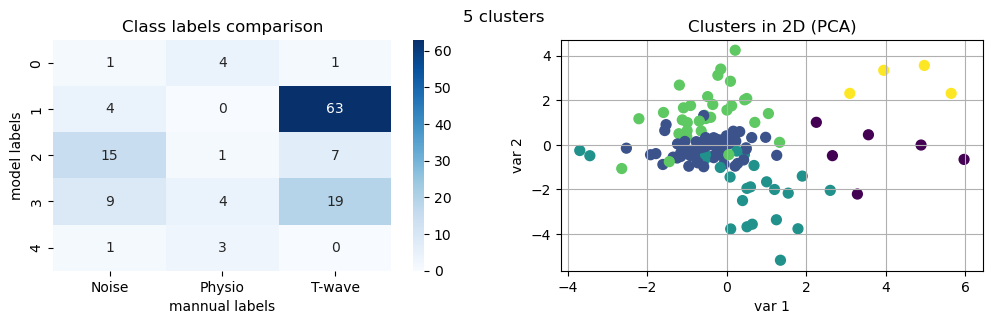

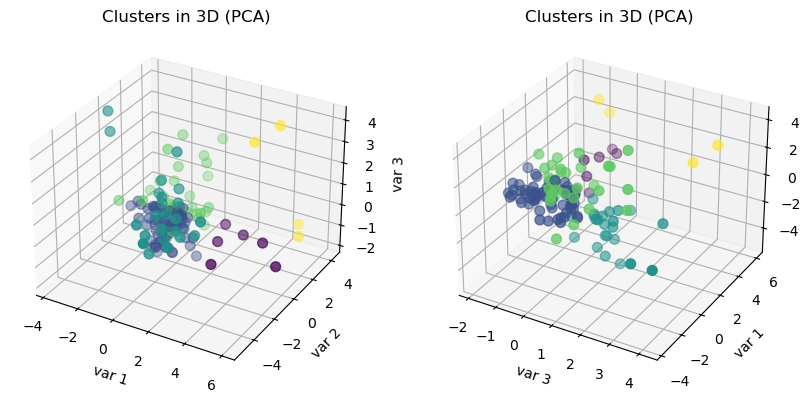

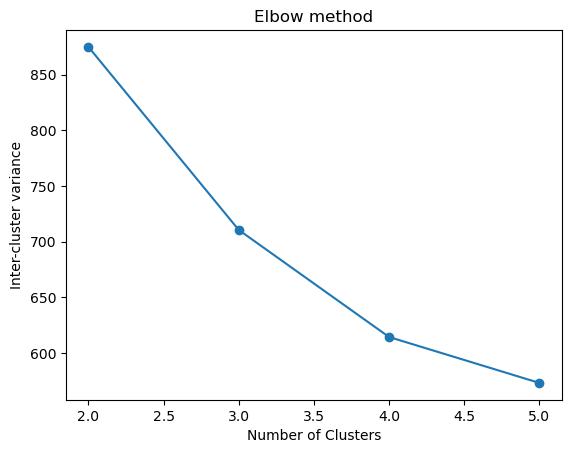

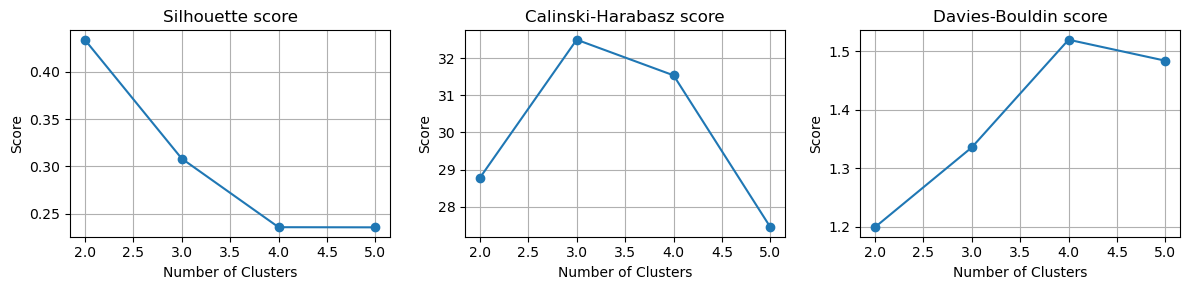

In [28]:
var_scores = []
silh_scores = []
ch_scores = []
db_scores = []

for n_clusters in range(2, 6):
    model = KMeans(n_clusters=n_clusters, random_state=37)
    model.fit(errors2)
    labels = model.labels_

    ## SCORES ##

    # Elbow method
    var_scores.append(model.inertia_)

    # Silhouette
    silh_scores.append(silhouette_score(errors2, labels))

    # Calinski-Harabasz
    ch_scores.append(calinski_harabasz_score(errors2, labels))

    # Davies-Bouldin
    db_scores.append(davies_bouldin_score(errors2, labels))

    SCORE_rows.append(['Kmeans', f'num clusters: {n_clusters}', silhouette_score(errors2, labels), calinski_harabasz_score(errors2, labels), davies_bouldin_score(errors2, labels)])

    ## VISUAL ANALYSIS ##
    fig = plt.figure(figsize=(12, 3))

    # Class labels comparison
    matrix = pd.crosstab(labels, errors_classes['error_class_label'])
    ax1 = fig.add_subplot(121)
    sns.heatmap(matrix, annot=True, cmap="Blues")
    ax1.set_title("Class labels comparison")
    ax1.set_xlabel('mannual labels')
    ax1.set_ylabel('model labels')
    
    # PCA 2D
    pca = PCA(n_components=2)
    errors_pca2 = pca.fit_transform(errors2)
    ax2 = fig.add_subplot(122)
    ax2.scatter(errors_pca2[:, 0], errors_pca2[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 2D (PCA)")
    ax2.set_xlabel("var 1")
    ax2.set_ylabel("var 2")
    ax2.grid(True)
    
    fig.suptitle(f'{n_clusters} clusters')
    plt.show()
    
    # PCA 3D
    fig = plt.figure(figsize=(10, 5))
    pca = PCA(n_components=3)
    errors_pca3 = pca.fit_transform(errors2)
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(errors_pca3[:, 0], errors_pca3[:, 1], errors_pca3[:, 2], c=labels, cmap='viridis', s=50)
    ax1.set_title("Clusters in 3D (PCA)")
    ax1.set_xlabel("var 1")
    ax1.set_ylabel("var 2")
    ax1.set_zlabel("var 3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(errors_pca3[:, 2], errors_pca3[:, 0], errors_pca3[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 3D (PCA)")
    ax2.set_xlabel("var 3")
    ax2.set_ylabel("var 1")
    ax2.set_zlabel("var 2")

    plt.show()

# Plot the elbow method
plt.plot(range(2, 6), var_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inter-cluster variance')
plt.title('Elbow method')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 

# Silhouette score
axes[0].plot(range(2, 6), silh_scores, marker='o')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')
axes[0].set_title('Silhouette score')
axes[0].grid(True)

# Calinski-Harabasz score
axes[1].plot(range(2, 6), ch_scores, marker='o')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Score')
axes[1].set_title('Calinski-Harabasz score')
axes[1].grid(True)

# Davies-Bouldin score
axes[2].plot(range(2, 6), db_scores, marker='o')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Score')
axes[2].set_title('Davies-Bouldin score')
axes[2].grid(True)

plt.tight_layout()
plt.show()
silh_scores_km = silh_scores
ch_scores_km = ch_scores
db_scores_km = db_scores

### Model 2: Hierarchical clustering (Agglomerative, Ward linkage)

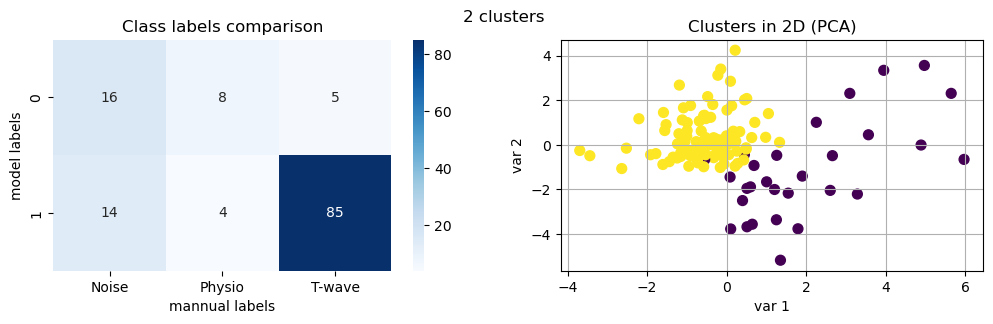

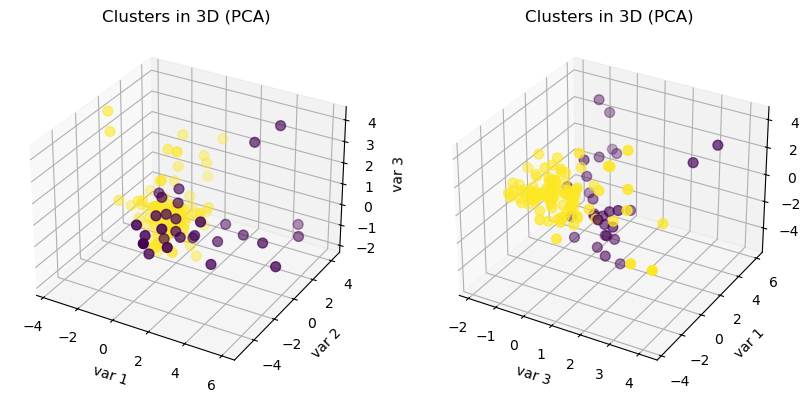

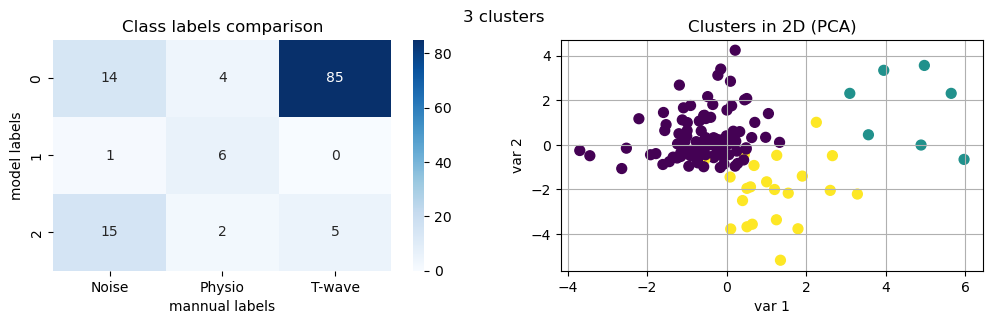

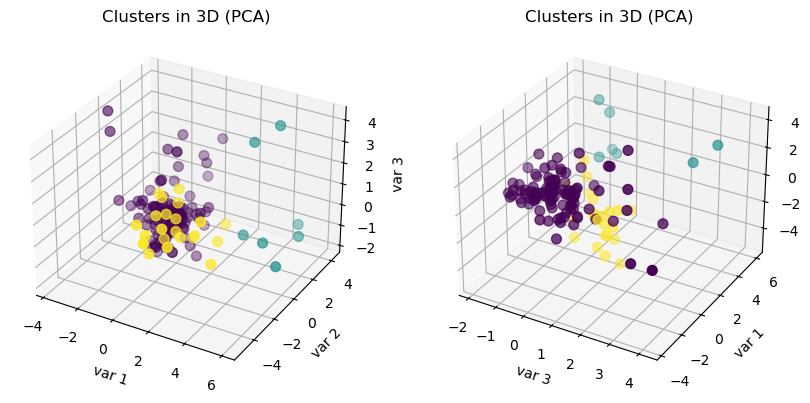

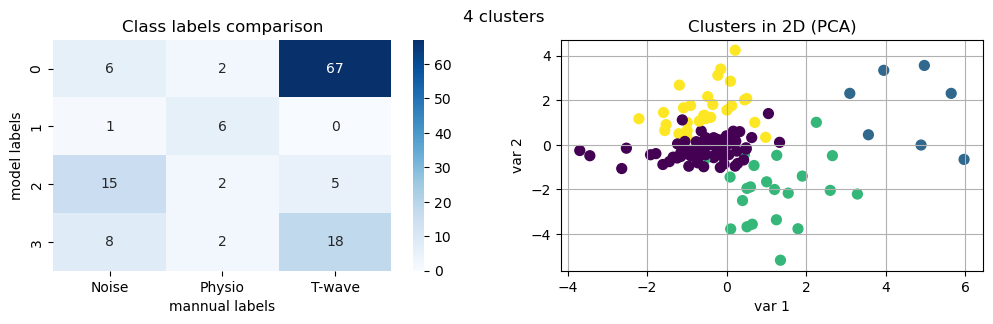

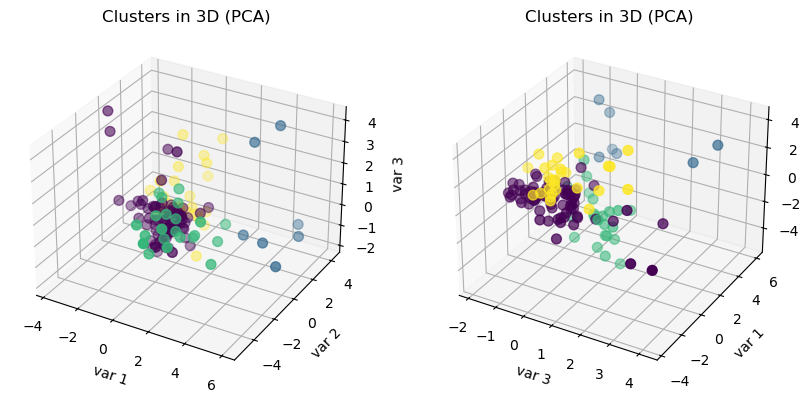

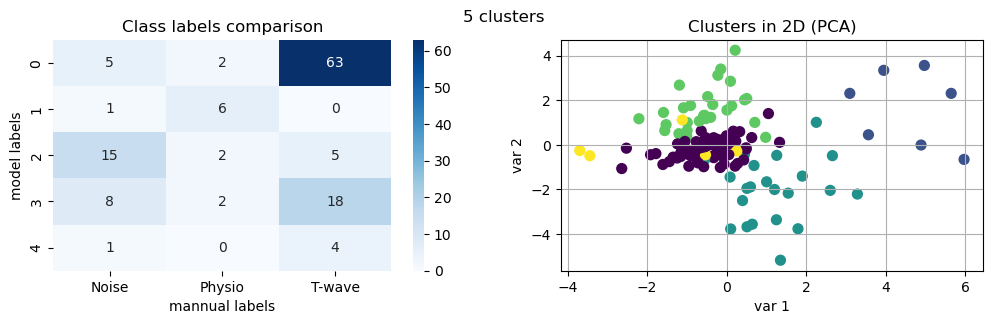

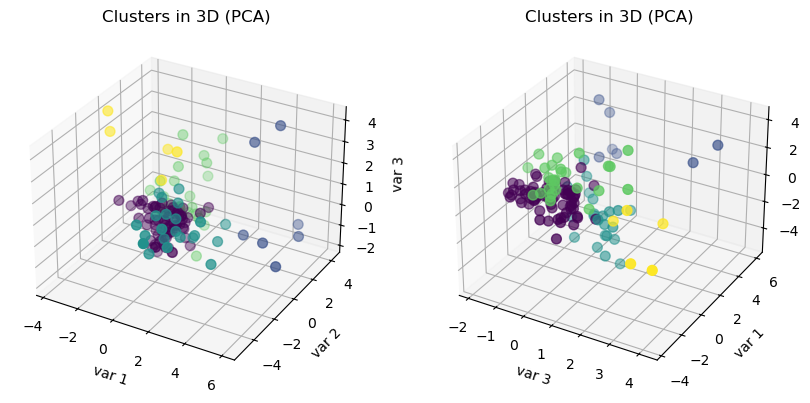

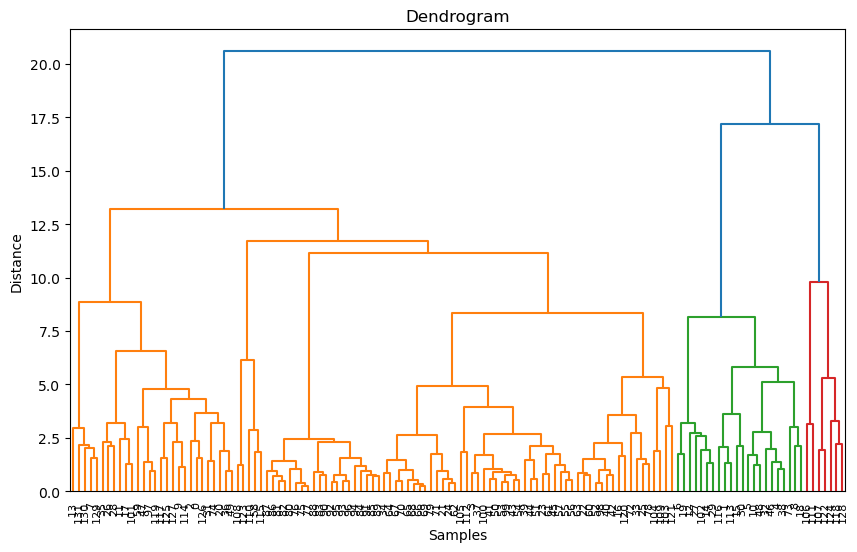

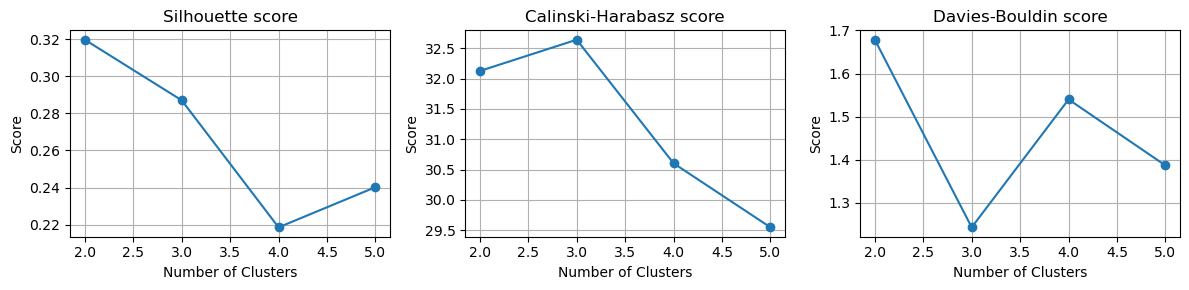

In [29]:
#var_scores = []
silh_scores = []
ch_scores = []
db_scores = []

for n_clusters in range(2, 6):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    model.fit(errors2)
    labels = model.labels_

    ## SCORES ##

    # Elbow method
    #var_scores.append(model.inertia_)

    # Silhouette
    silh_scores.append(silhouette_score(errors2, labels))

    # Calinski-Harabasz
    ch_scores.append(calinski_harabasz_score(errors2, labels))

    # Davies-Bouldin
    db_scores.append(davies_bouldin_score(errors2, labels))

    SCORE_rows.append(['Hierarchical', f'num clusters: {n_clusters}', silhouette_score(errors2, labels), calinski_harabasz_score(errors2, labels), davies_bouldin_score(errors2, labels)])
    
    ## VISUAL ANALYSIS ##
    fig = plt.figure(figsize=(12, 3))

    # Class labels comparison
    matrix = pd.crosstab(labels, errors_classes['error_class_label'])
    ax1 = fig.add_subplot(121)
    sns.heatmap(matrix, annot=True, cmap="Blues")
    ax1.set_title("Class labels comparison")
    ax1.set_xlabel('mannual labels')
    ax1.set_ylabel('model labels')
    
    # PCA 2D
    pca = PCA(n_components=2)
    errors_pca2 = pca.fit_transform(errors2)
    ax2 = fig.add_subplot(122)
    ax2.scatter(errors_pca2[:, 0], errors_pca2[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 2D (PCA)")
    ax2.set_xlabel("var 1")
    ax2.set_ylabel("var 2")
    ax2.grid(True)
    
    fig.suptitle(f'{n_clusters} clusters')
    plt.show()
    
    # PCA 3D
    fig = plt.figure(figsize=(10, 5))
    pca = PCA(n_components=3)
    errors_pca3 = pca.fit_transform(errors2)
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(errors_pca3[:, 0], errors_pca3[:, 1], errors_pca3[:, 2], c=labels, cmap='viridis', s=50)
    ax1.set_title("Clusters in 3D (PCA)")
    ax1.set_xlabel("var 1")
    ax1.set_ylabel("var 2")
    ax1.set_zlabel("var 3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(errors_pca3[:, 2], errors_pca3[:, 0], errors_pca3[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 3D (PCA)")
    ax2.set_xlabel("var 3")
    ax2.set_ylabel("var 1")
    ax2.set_zlabel("var 2")
    
    plt.show()

# Dendrogram
L = linkage(errors2, method='ward')
plt.figure(figsize=(10,6))
dendrogram(L, labels=errors2.index, leaf_rotation=90, leaf_font_size=8)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()
    
# Plot the elbow method
#plt.plot(range(2, 6), var_scores, marker='o')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inter-cluster variance')
#plt.title('Elbow method')
#plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 

# Silhouette score
axes[0].plot(range(2, 6), silh_scores, marker='o')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')
axes[0].set_title('Silhouette score')
axes[0].grid(True)

# Calinski-Harabasz score
axes[1].plot(range(2, 6), ch_scores, marker='o')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Score')
axes[1].set_title('Calinski-Harabasz score')
axes[1].grid(True)

# Davies-Bouldin score
axes[2].plot(range(2, 6), db_scores, marker='o')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Score')
axes[2].set_title('Davies-Bouldin score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

silh_scores_agg = silh_scores
ch_scores_agg = ch_scores
db_scores_agg = db_scores

### Model 3: DBSCAN

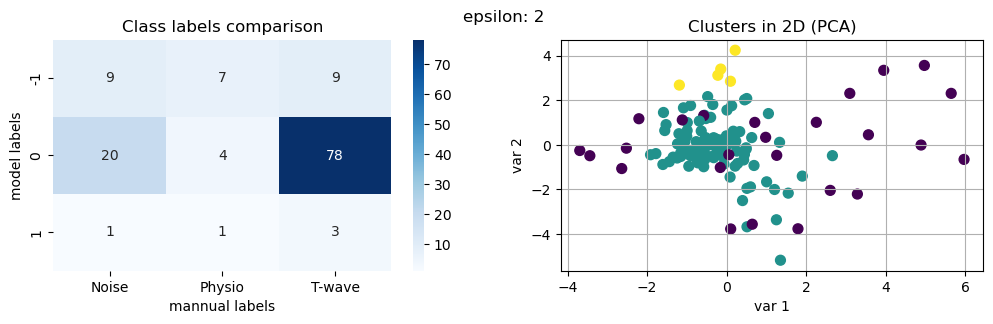

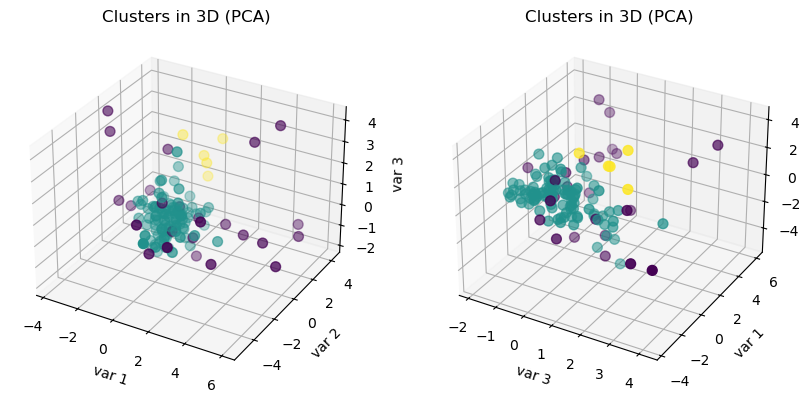

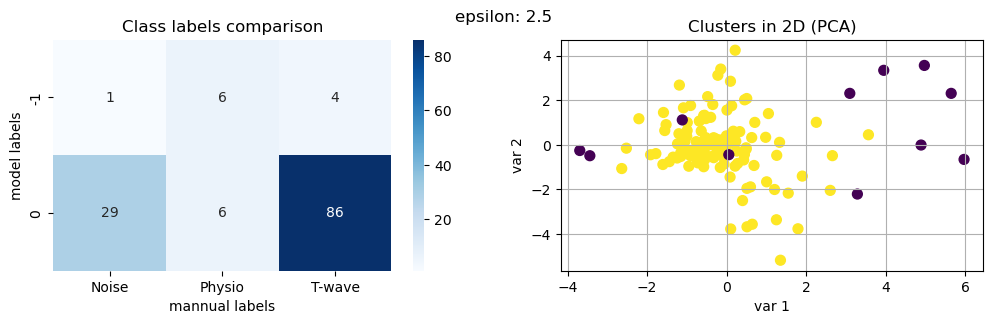

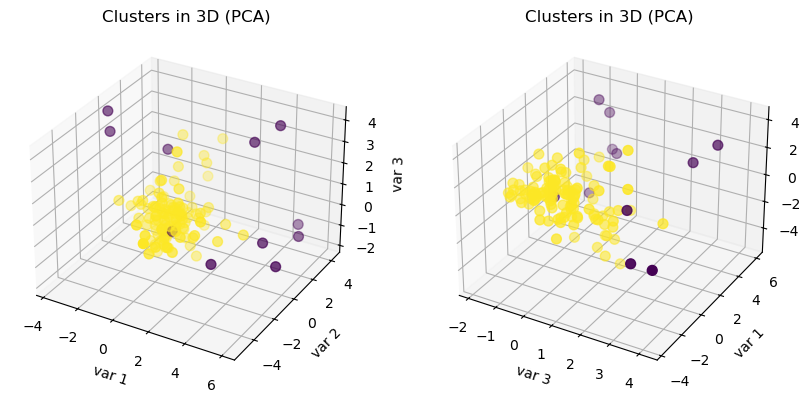

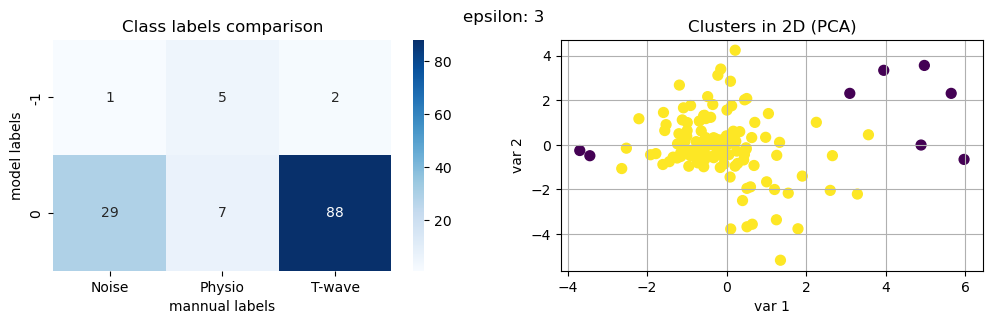

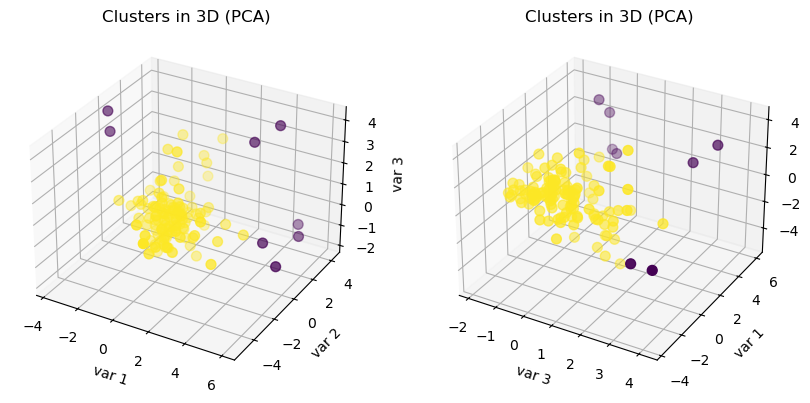

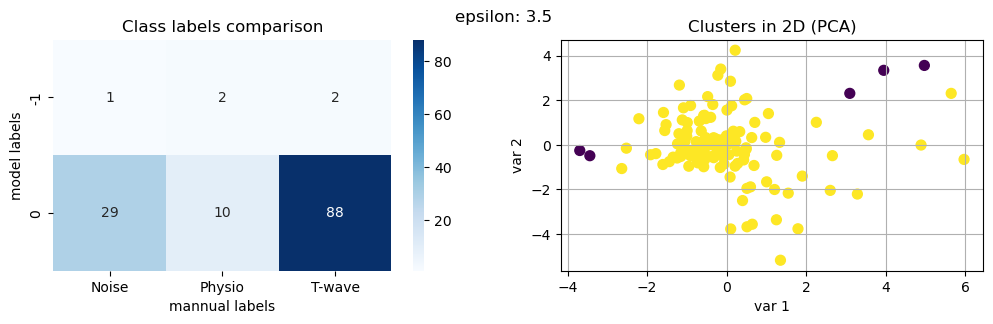

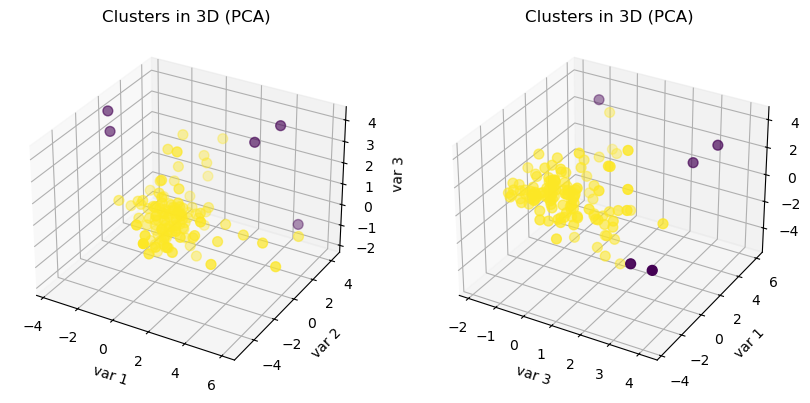

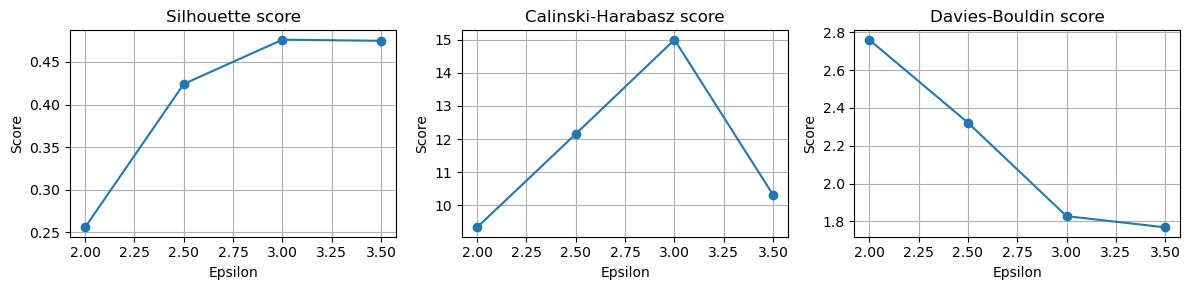

In [30]:
#var_scores = []
silh_scores = []
ch_scores = []
db_scores = []
epsilons = [2, 2.5, 3, 3.5]
for e in epsilons:
    model = DBSCAN(eps=e)
    model.fit(errors2)
    labels = model.labels_

    ## SCORES ##

    # Elbow method
    #var_scores.append(model.inertia_)

    # Silhouette
    silh_scores.append(silhouette_score(errors2, labels))

    # Calinski-Harabasz
    ch_scores.append(calinski_harabasz_score(errors2, labels))

    # Davies-Bouldin
    db_scores.append(davies_bouldin_score(errors2, labels))

    SCORE_rows.append(['DBSCAN', f'epsilon: {e}', silhouette_score(errors2, labels), calinski_harabasz_score(errors2, labels), davies_bouldin_score(errors2, labels)])
    
    ## VISUAL ANALYSIS ##
    fig = plt.figure(figsize=(12, 3))

    # Class labels comparison
    matrix = pd.crosstab(labels, errors_classes['error_class_label'])
    ax1 = fig.add_subplot(121)
    sns.heatmap(matrix, annot=True, cmap="Blues")
    ax1.set_title("Class labels comparison")
    ax1.set_xlabel('mannual labels')
    ax1.set_ylabel('model labels')
    
    # PCA 2D
    pca = PCA(n_components=2)
    errors_pca2 = pca.fit_transform(errors2)
    ax2 = fig.add_subplot(122)
    ax2.scatter(errors_pca2[:, 0], errors_pca2[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 2D (PCA)")
    ax2.set_xlabel("var 1")
    ax2.set_ylabel("var 2")
    ax2.grid(True)
    
    fig.suptitle(f'epsilon: {e}')
    plt.show()
    
    # PCA 3D
    fig = plt.figure(figsize=(10, 5))
    pca = PCA(n_components=3)
    errors_pca3 = pca.fit_transform(errors2)
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(errors_pca3[:, 0], errors_pca3[:, 1], errors_pca3[:, 2], c=labels, cmap='viridis', s=50)
    ax1.set_title("Clusters in 3D (PCA)")
    ax1.set_xlabel("var 1")
    ax1.set_ylabel("var 2")
    ax1.set_zlabel("var 3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(errors_pca3[:, 2], errors_pca3[:, 0], errors_pca3[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 3D (PCA)")
    ax2.set_xlabel("var 3")
    ax2.set_ylabel("var 1")
    ax2.set_zlabel("var 2")
    
    plt.show()

# Plot the elbow method
#plt.plot(range(2, 6), var_scores, marker='o')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inter-cluster variance')
#plt.title('Elbow method')
#plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 

# Silhouette score
axes[0].plot(epsilons, silh_scores, marker='o')
axes[0].set_xlabel('Epsilon')
axes[0].set_ylabel('Score')
axes[0].set_title('Silhouette score')
axes[0].grid(True)

# Calinski-Harabasz score
axes[1].plot(epsilons, ch_scores, marker='o')
axes[1].set_xlabel('Epsilon')
axes[1].set_ylabel('Score')
axes[1].set_title('Calinski-Harabasz score')
axes[1].grid(True)

# Davies-Bouldin score
axes[2].plot(epsilons, db_scores, marker='o')
axes[2].set_xlabel('Epsilon')
axes[2].set_ylabel('Score')
axes[2].set_title('Davies-Bouldin score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Model 4: Gaussian Mixtures Models

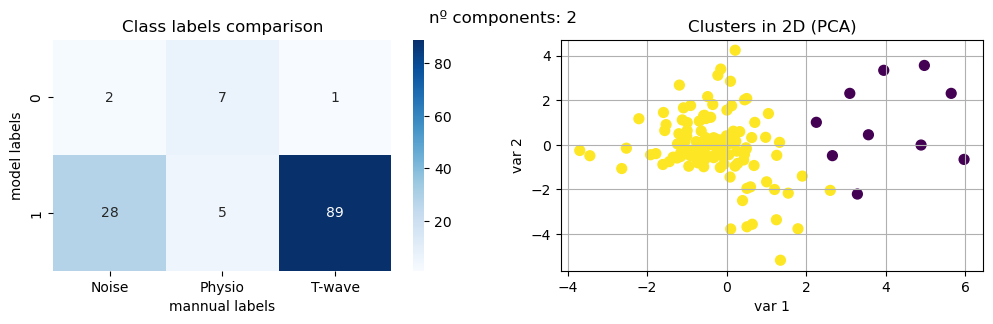

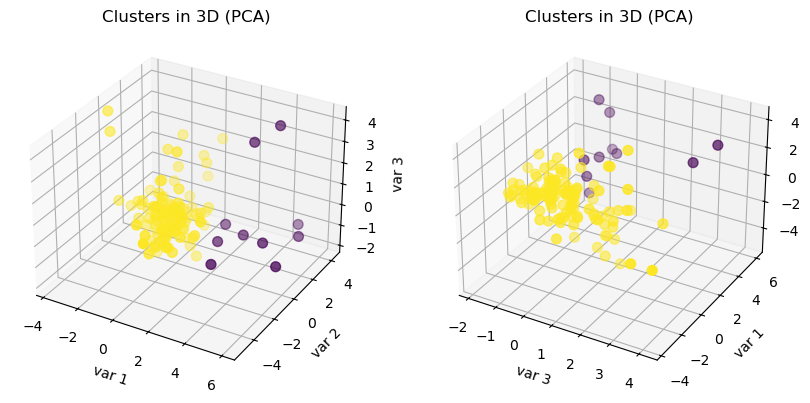

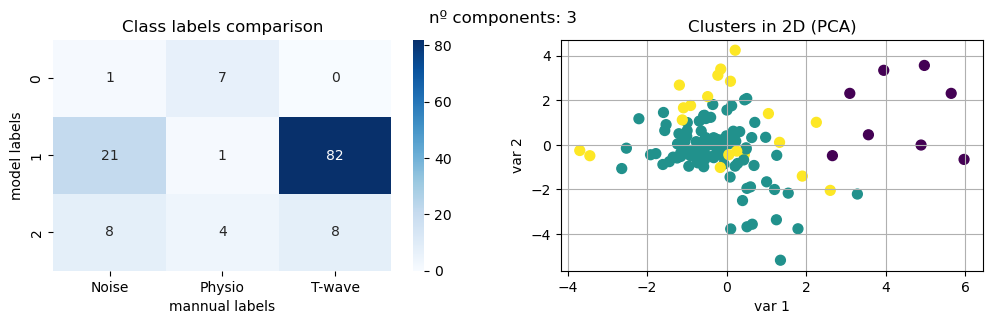

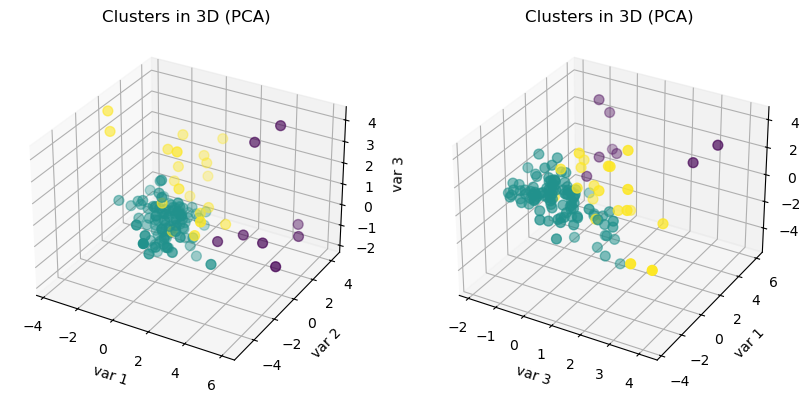

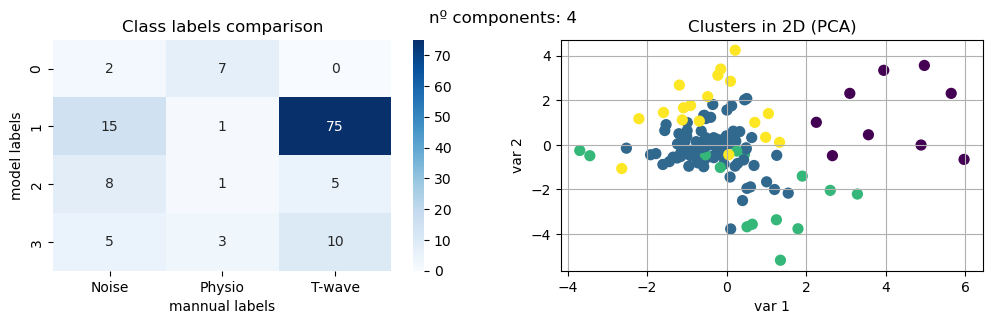

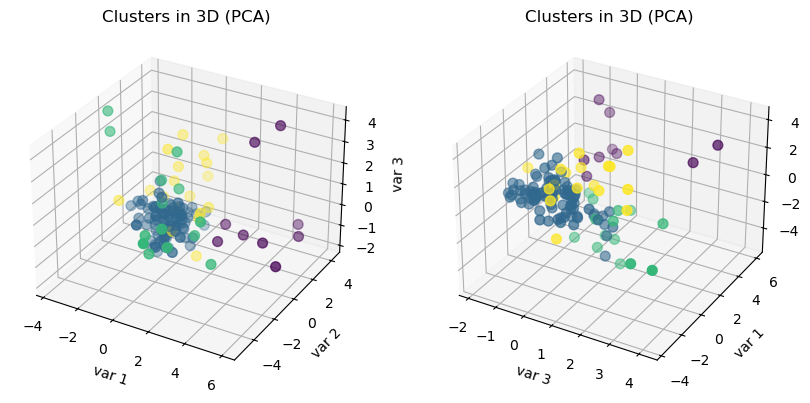

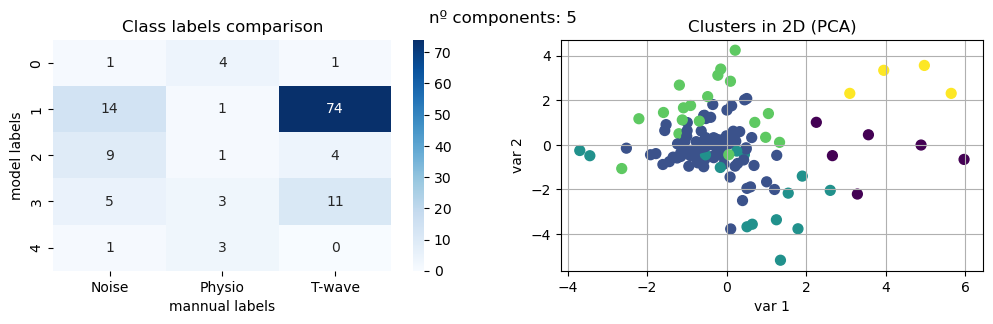

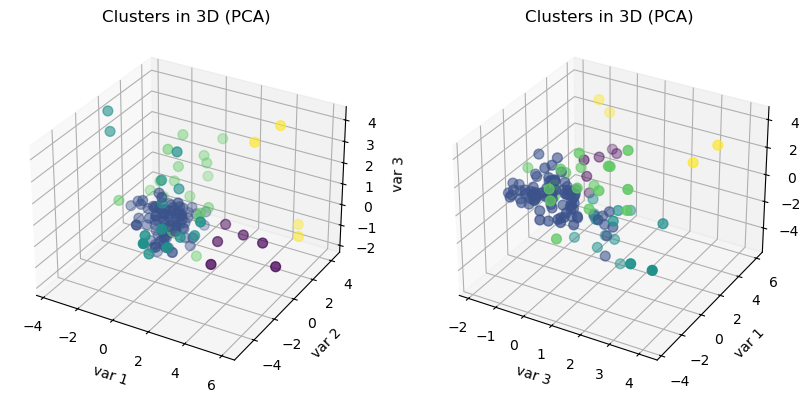

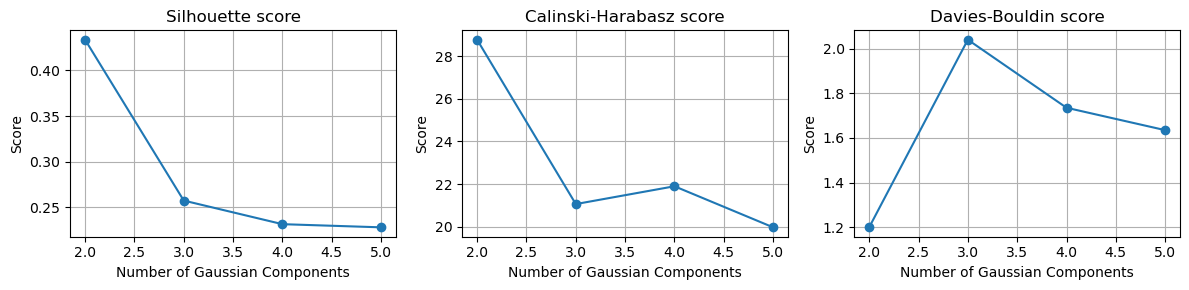

In [31]:
#var_scores = []
silh_scores = []
ch_scores = []
db_scores = []
N = [2, 3, 4, 5]
for n in N:
    model = GaussianMixture(n_components=n, covariance_type='full', random_state=37)
    model.fit(errors2)
    labels = model.predict(errors2)

    ## SCORES ##

    # Elbow method
    #var_scores.append(model.inertia_)

    # Silhouette
    silh_scores.append(silhouette_score(errors2, labels))

    # Calinski-Harabasz
    ch_scores.append(calinski_harabasz_score(errors2, labels))

    # Davies-Bouldin
    db_scores.append(davies_bouldin_score(errors2, labels))

    SCORE_rows.append(['GMM', f'num components: {n}', silhouette_score(errors2, labels), calinski_harabasz_score(errors2, labels), davies_bouldin_score(errors2, labels)])

    ## VISUAL ANALYSIS ##
    fig = plt.figure(figsize=(12, 3))

    # Class labels comparison
    matrix = pd.crosstab(labels, errors_classes['error_class_label'])
    ax1 = fig.add_subplot(121)
    sns.heatmap(matrix, annot=True, cmap="Blues")
    ax1.set_title("Class labels comparison")
    ax1.set_xlabel('mannual labels')
    ax1.set_ylabel('model labels')
    
    # PCA 2D
    pca = PCA(n_components=2)
    errors_pca2 = pca.fit_transform(errors2)
    ax2 = fig.add_subplot(122)
    ax2.scatter(errors_pca2[:, 0], errors_pca2[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 2D (PCA)")
    ax2.set_xlabel("var 1")
    ax2.set_ylabel("var 2")
    ax2.grid(True)
    
    fig.suptitle(f'nº components: {n}')
    plt.show()
    
    # PCA 3D
    fig = plt.figure(figsize=(10, 5))
    pca = PCA(n_components=3)
    errors_pca3 = pca.fit_transform(errors2)
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(errors_pca3[:, 0], errors_pca3[:, 1], errors_pca3[:, 2], c=labels, cmap='viridis', s=50)
    ax1.set_title("Clusters in 3D (PCA)")
    ax1.set_xlabel("var 1")
    ax1.set_ylabel("var 2")
    ax1.set_zlabel("var 3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(errors_pca3[:, 2], errors_pca3[:, 0], errors_pca3[:, 1], c=labels, cmap='viridis', s=50)
    ax2.set_title("Clusters in 3D (PCA)")
    ax2.set_xlabel("var 3")
    ax2.set_ylabel("var 1")
    ax2.set_zlabel("var 2")
    
    plt.show()

# Plot the elbow method
#plt.plot(range(2, 6), var_scores, marker='o')
#plt.xlabel('Number of Clusters')
#plt.ylabel('Inter-cluster variance')
#plt.title('Elbow method')
#plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 

# Silhouette score
axes[0].plot(N, silh_scores, marker='o')
axes[0].set_xlabel('Number of Gaussian Components')
axes[0].set_ylabel('Score')
axes[0].set_title('Silhouette score')
axes[0].grid(True)

# Calinski-Harabasz score
axes[1].plot(N, ch_scores, marker='o')
axes[1].set_xlabel('Number of Gaussian Components')
axes[1].set_ylabel('Score')
axes[1].set_title('Calinski-Harabasz score')
axes[1].grid(True)

# Davies-Bouldin score
axes[2].plot(N, db_scores, marker='o')
axes[2].set_xlabel('Number of Gaussian Components')
axes[2].set_ylabel('Score')
axes[2].set_title('Davies-Bouldin score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

silh_scores_gmm = silh_scores
ch_scores_gmm = ch_scores
db_scores_gmm = db_scores

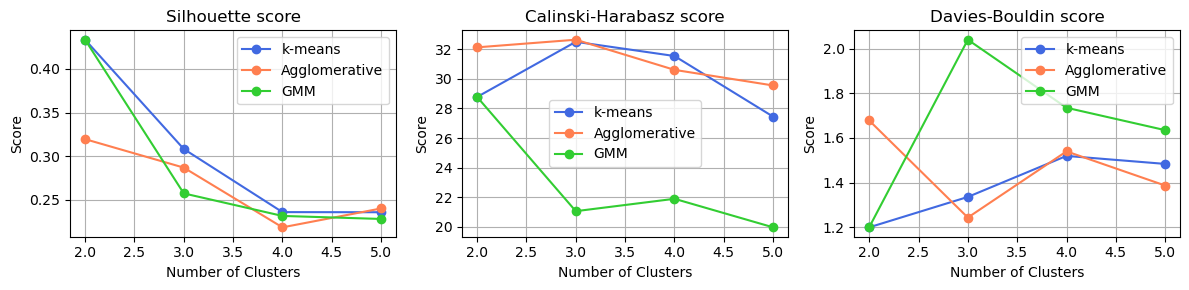

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 

# Silhouette score
axes[0].plot(range(2, 6), silh_scores_km, marker='o', c='royalblue', label='k-means')
axes[0].plot(range(2, 6), silh_scores_agg, marker='o', c='coral', label='Agglomerative')
axes[0].plot(range(2, 6), silh_scores_gmm, marker='o', c='limegreen', label='GMM')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')
axes[0].set_title('Silhouette score')
axes[0].legend()
axes[0].grid(True)

# Calinski-Harabasz score
axes[1].plot(range(2, 6), ch_scores_km, marker='o', c='royalblue', label='k-means')
axes[1].plot(range(2, 6), ch_scores_agg, marker='o', c='coral', label='Agglomerative')
axes[1].plot(range(2, 6), ch_scores_gmm, marker='o', c='limegreen', label='GMM')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Score')
axes[1].set_title('Calinski-Harabasz score')
axes[1].legend()
axes[1].grid(True)

# Davies-Bouldin score
axes[2].plot(range(2, 6), db_scores_km, marker='o', c='royalblue', label='k-means')
axes[2].plot(range(2, 6), db_scores_agg, marker='o', c='coral', label='Agglomerative')
axes[2].plot(range(2, 6), db_scores_gmm, marker='o', c='limegreen', label='GMM')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('Score')
axes[2].set_title('Davies-Bouldin score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [39]:
SCORE = pd.DataFrame(SCORE_rows, columns = SCORE_columns)
SCORE['db_inv'] = 1/SCORE['davies-bouldin']
SCORE[['silh_norm', 'ch_norm', 'db_norm']] = MinMaxScaler().fit_transform(SCORE[['silhouette', 'calinski-harabasz', 'db_inv']])
SCORE['comb_score'] = 0.5*SCORE['silh_norm']+0.4*SCORE['ch_norm']+0.1*SCORE['db_norm']

In [41]:
SCORE.sort_values(by='comb_score', ascending=False, inplace=True)
SCORE.head(6)

model             params  silhouette  calinski-harabasz  \
0         Kmeans    num clusters: 2    0.433532          28.773151   
12           GMM  num components: 2    0.433532          28.773151   
1         Kmeans    num clusters: 3    0.308344          32.498328   
4   Hierarchical    num clusters: 2    0.319616          32.123567   
10        DBSCAN         epsilon: 3    0.476030          15.002633   
5   Hierarchical    num clusters: 3    0.286995          32.638791   

    davies-bouldin    db_inv  silh_norm   ch_norm   db_norm  comb_score  
0         1.199207  0.833884   0.834929  0.834157  1.000000    0.851127  
12        1.199207  0.833884   0.834929  0.834157  1.000000    0.851127  
1         1.335558  0.748751   0.348676  0.993974  0.819528    0.653880  
4         1.678566  0.595747   0.392457  0.977896  0.495179    0.636905  
10        1.827473  0.547204   1.000000  0.243378  0.392274    0.636579  
5         1.243005  0.804502   0.265751  1.000000  0.937713    0.626647

In [42]:
SCORE.to_csv("Unsupervised_learning/results_unsup.csv", index=False, encoding="utf-8", sep=";")